In [1]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt

# ------- Load dependencies
import pandas as pd
import numpy as np
import random
import seaborn as sns
import gdal, os, osr, warnings

# Curve fitting and linear models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy # R-esque version of formula declaration

# ------- Working directory
dataDir = 'Y:/DanK/DinkeyCreek/ProjectedClimate_MS/'

# ---- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection


C:\Anaconda\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [97]:
def centOutputGen(dataDir, simname):
    wkDir_reps =  dataDir + simname + '/'
    centFileName = 'Century-succession-log.csv'
    centFileNameM = 'Century-succession-monthly-log.csv'
    sppBioName = 'spp-biomass-log.csv'

    repnames = next(os.walk(wkDir_reps))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        repnum = rep.split('replicate')[1]
        wkDir_data = wkDir_reps + 'replicate' + repnum + '/'
        cent = pd.read_csv(wkDir_data + centFileName)
        cent['rep'] = int(repnum)
        centM = pd.read_csv(wkDir_data + centFileNameM)
        centM['rep'] = int(repnum)
        sppBio = pd.read_csv(wkDir_data + sppBioName)
        sppBio['rep'] = int(repnum)

        if idx == 0: 
            centTot = cent
            centTotM = centM
            sppBioTot = sppBio

        else:
            centTot = pd.concat((centTot, cent))
            centTotM = pd.concat((centTotM, centM))
            sppBioTot = pd.concat((sppBioTot, sppBio))

        idx = idx + 1
    return centTot, centTotM, sppBioTot


def genCentWeightedMeansDF(aggregatedAnnualCentFile, simName):
    simCentDF = aggregatedAnnualCentFile
    # ------- Create new vars in Cent file and handle unit conversion ------- #
    simCentDF['TEC'] = (simCentDF['SOMTC'] + simCentDF['AGB']* 0.5 ) * 0.01 # Add total ecosystem carbon, Mg/ha
    simCentDF['AGBc'] = simCentDF['AGB']* 0.5 * 0.01 # Convert AGB from g /m^2 biomass to Mg/ha C
    simCentDF['NEEC'] = simCentDF['NEEC'] * -1 * 0.01 # Convert NEE sign convention 
    simCentDF['NECB'] = simCentDF['NEEC'] - (simCentDF['FireCEfflux'] * 0.01)
    activeArea = simCentDF.NumSites.unique().sum() # Calculate total sites in the simulation

    # ------- Generate mean and std of weighted ecoregion data ------- #
    simCentDF['TECw'] = simCentDF.TEC * (simCentDF.NumSites / activeArea)
    simCentDF['AGBw'] = simCentDF.AGBc * (simCentDF.NumSites / activeArea)
    simCentDF['NEECw'] = simCentDF.NEEC * (simCentDF.NumSites / activeArea)
    
    # Convert the fire efflux from g/m2 to Mg/ha (already in units of C), and 
    # produce the ecoregion weighted per hectare value
    simCentDF['FireCEffluxw'] = simCentDF.FireCEfflux * 0.01 * (simCentDF.NumSites / activeArea)
    simCentDF['NECBw'] = simCentDF['NEECw'] - simCentDF['FireCEffluxw']
    
    # Take mean and std across reps
    naiveMean = simCentDF.groupby(['EcoregionName','Time']).mean()
    naiveStd = simCentDF.groupby(['EcoregionName','Time']).std()

    # Generate a dataframe for that we can leverage when we want to ask questions
    # about the cumulative nature of some century variable, by replicate.
    naiveSum= simCentDF.groupby(['rep']).sum()

    naiveMean['NEECw_std'] = naiveStd.NEEC * (naiveMean.NumSites / activeArea) # 
    naiveMean['AGBw_std'] = naiveStd.AGBc * (naiveMean.NumSites / activeArea)
    naiveMean['TECw_std'] = naiveStd.TEC * (naiveMean.NumSites / activeArea)
    naiveMean['FireCEffluxw_std'] = naiveStd.FireCEfflux * (naiveMean.NumSites / activeArea)
    naiveMean['NECBw_std'] = naiveStd.NECBw * (naiveMean.NumSites / activeArea)
    resetMean = naiveMean.reset_index()
    resetSum = naiveSum.reset_index()
    repsTot = simCentDF.reset_index()
    
    # ------- Generate region-wide weighted mean of all ecoregions ------ #
    weightedMean = resetMean.groupby('Time').sum()
    index = pd.date_range('2000-1-1', periods=len(weightedMean), freq='1A')
    weightedMean.index = index
    weightedMean[weightedMean.NEECw == 0] = np.nan
    weightedMean['Sim'] = simName
    resetSum['Sim'] = simName
    simCentDF['Sim'] = simName

    return weightedMean, simCentDF, resetSum

def plotSimulationCarbon(weightedMeansDF):
    weightedMean = weightedMeansDF
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(16,10))
    plt.subplots_adjust(wspace = 0.3)
    simidx = 0
    simColors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c', 'black']
    for sim in np.unique(weightedMean.Sim):
        print sim
        simMean = weightedMean[weightedMean.Sim == sim]
        simMean.AGBw.plot(ax = ax1, color = simColors[simidx])
        simMean.TECw.plot(ax = ax2, color = simColors[simidx])
        simMean.NEECw.plot(ax = ax3, color = simColors[simidx])
        simMean.FireCEffluxw.cumsum().plot(ax = ax4, color = simColors[simidx])
        simMean.NECBwHA = simMean.NECBw * 0.01 # Mg/ha for cumulative curves
        simMean.NECBwHA_stdHA = simMean.NECBw_std * 0.01 # Mg/ha for cumulative curves
        simMean.NECBwHA.plot(ax = ax6, color = simColors[simidx])
        

        ax1.fill_between(simMean.index, 
                         simMean.AGBw+simMean.AGBw_std, 
                         simMean.AGBw-simMean.AGBw_std, 
                         alpha = 0.2, color = simColors[simidx])
 
        ax2.fill_between(simMean.index, 
                         simMean.TECw+simMean.TECw_std, 
                         simMean.TECw-simMean.TECw_std, 
                         alpha = 0.2, color = simColors[simidx])
        
        ax3.fill_between(simMean.index, 
                         simMean.NEECw+simMean.NEECw_std, 
                         simMean.NEECw-simMean.NEECw_std, 
                         alpha = 0.2, color = simColors[simidx])
        
        #Replaced the cumulatiev curves with boxplots of cumulative C emissions from fire
        ax4.fill_between(simMean.index, 
                         simMean.FireCEffluxw.cumsum()+simMean.FireCEffluxw_std, 0,
                         alpha = 0.2, color = simColors[simidx])
        
        ax6.fill_between(simMean.index, 
                         simMean.NECBwHA+simMean.NECBwHA_stdHA, 
                         simMean.NECBwHA-simMean.NECBwHA_stdHA, 
                         alpha = 0.2, color = simColors[simidx])
        
        simidx = simidx + 1

    # ------ Aesthetics ------ #
    ax1.set_ylabel('AGB (MgC ha $^{-1}$)')
    ax2.set_ylabel('TEC (Mg ha $^{-1}$)')
    ax3.set_ylabel('NEE (gC m$^{-2}$)')
    ax4.set_ylabel('Cumulative Fire Efflux gC m$^{-2}$)')
    ax5.set_ylabel('AGB (MgC ha $^{-1}$)')
    ax6.set_ylabel('Cumulative NECB MgC ha$^{-1}$)')
    
    ax2.set_xlabel('Simulation Year')
    ax5.set_xlabel('Model Simulation')
    
    lastTen = weightedMean[weightedMean.index.year >= 2090]
    #g = sns.boxplot(x="Sim", y=weightedMean.FireCEffluxw,
    #              data=weightedMean, ax = ax4, palette=simColors)
    ax4.set_xticklabels(lastTen.Sim.unique(),rotation = 45)
    #ax4.set_ylim([0,1000])

    g = sns.boxplot(x="Sim", y="AGBw",
                  data=lastTen, ax = ax5, palette=simColors)
    ax5.set_xticklabels(lastTen.Sim.unique(),rotation = 45)
    
    sns.despine()
    sns.set_style('white')
    sns.set_context('notebook', font_scale=1.5)

    ax1.legend(np.unique(weightedMean.Sim), loc = 'lower right')
    
def severityStack(rasterLoc, runLength):
    rasterlist = []
    timesteps = np.linspace(1,runLength,runLength)
    
    repnames = next(os.walk(rasterLoc))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        counter = 0
        repnum = rep.split('replicate')[1]
        for time in timesteps:  
            wkDir_data = rasterLoc + '/' 'replicate' + repnum + '/' + 'fire/'
            sevmap = 'severity-' + str(int(time)) + '.img'
            src_ds = gdal.Open( wkDir_data + sevmap ) 
            sevarray = src_ds.ReadAsArray()
            sevarray = sevarray.astype('float')
            rasterlist.append(sevarray)
            
    return rasterlist

def thinStack(rasterLoc, runLength):
    rasterlist = []
    thinlist = []
    rxfirelist = []
    timesteps = np.linspace(1,runLength,runLength)
    
    repnames = next(os.walk(rasterLoc))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        counter = 0
        repnum = rep.split('replicate')[1]
        for time in timesteps:  
            wkDir_data = rasterLoc + '/' 'replicate' + repnum + '/ThinMAP/'
            thinmap = 'biomass-removed-' + str(int(time)) + '.img'
            src_ds = gdal.Open( wkDir_data + thinmap ) 
            thinarray = src_ds.ReadAsArray()
            thinarray = thinarray.astype('float')
            rasterlist.append(thinarray)
            if time < 10:
                thinlist.append(thinarray)
            else:
                rxfirelist.append(thinarray)
            
    return rasterlist, thinlist, rxfirelist


def severityGen(rasterList):
    rasterStack = np.dstack(rasterList)  
    rasterAdj = rasterStack - 2
    rasterAdj[rasterAdj < 0] = np.nan
    meanSev = np.nanmean(rasterAdj, axis = 2)
    varSev = np.nanvar(rasterAdj, axis = 2)
    return meanSev, varSev

def thinGen(rasterList):
    rasterStack = np.dstack(rasterList)
    countTHIN = np.count_nonzero(rasterStack, axis = 2)
    rasterStack[rasterStack == 0] = np.nan
    cumTHIN = np.nansum(rasterStack, axis = 2)
    varTHIN = np.nanvar(rasterStack, axis = 2)
    return countTHIN, cumTHIN, varTHIN

def plotTS(simsDF, simname, var, var_sd = None, ax = None, *args, **kwargs):
    # Grab figure axes if none stated
    if ax == None:
         ax = plt.gca()
                   
    simMean = simsDF[simsDF.Sim == simname]
    simMean[var].plot(ax = ax, *args, **kwargs)
    
    if var_sd != None:
        ax.fill_between(simMean.index, 
                    simMean[var]+3*simMean[var_sd]/np.sqrt(50), 
                    simMean[var]-3*simMean[var_sd]/np.sqrt(50), 
                    alpha = 0.3)
        
def plotTS_cumulative(simsDF, simname, var, var_sd = None, ax = None, *args, **kwargs):
    # Grab figure axes if none stated
    if ax == None:
         ax = plt.gca()
            
    simMean = simsDF[simsDF.Sim == simname]            
    simMean[var].cumsum().plot(ax = ax, *args, **kwargs)
    
    if var_sd != None:                 
        ax.fill_between(simMean.index, 
                 simMean[var].cumsum()+3*simMean[var_sd].cumsum()/np.sqrt(50), 
                 simMean[var].cumsum()-3*simMean[var_sd].cumsum()/np.sqrt(50), 
                 alpha = 0.3)

        
def plotRaster(image, ax=None, *args, **kwargs):

    # Grab figure axes if none stated
    if ax == None:
         ax = plt.gca()
                   
    # Normalize color scheme
    if 'norm' not in kwargs:
        vmin = kwargs.pop('vmin', None)
        vmax = kwargs.pop('vmax', None)
        if vmin is None:
            vmin = np.min(image) # or what ever
        if vmax is None:
            vmax = np.max(image)
        norm = matplotlib.colors.Normalize(vmin, vmax)
        kwargs['norm'] = norm

    #ax.figure.canvas.draw() # if you want to force a re-draw
    ax.imshow(image, *args, **kwargs)
    # Setup axes
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    
# Stacked bar chart code grabbed then modified from the web
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=1.2,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, edgecolor = 'k', color = 'white', hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5], title = 'Fire Severity')
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1], title = 'Fire Weather') 
    axe.add_artist(l1)
    return axe

def appendTreatments(totalDFs):
    warnings.filterwarnings("ignore")
    totalDFs['Trtmnt'] = 'No Management'
    totalDFs.Trtmnt[totalDFs.Sim == 'HSFPCCSM'] = 'HSFP'
    totalDFs.Trtmnt[totalDFs.Sim == 'HSFPCNRM'] = 'HSFP'
    totalDFs.Trtmnt[totalDFs.Sim == 'HSFPFGOALS'] = 'HSFP'
    totalDFs.Trtmnt[totalDFs.Sim == 'HSFPMIROC5'] = 'HSFP'

    totalDFs.Trtmnt[totalDFs.Sim == 'OpConCCSM'] = 'OpCon'
    totalDFs.Trtmnt[totalDFs.Sim == 'OpConCNRM'] = 'OpCon'
    totalDFs.Trtmnt[totalDFs.Sim == 'OpConFGOALS'] = 'OpCon'
    totalDFs.Trtmnt[totalDFs.Sim == 'OpConMIROC5'] = 'OpCon'
    warnings.filterwarnings("default")

    return totalDFs

def plotMinMaxMedReps(simCentDF, var, ax = None, *args, **kwargs):
    # Generate ecoregion weighted sum    
    summed = simCentDF.groupby(['Time','rep','Sim']).sum()

    # Reset the index for grouping
    reset_summed = summed.reset_index()

    # Create the min, max, and median DFs
    maxdf = reset_summed.groupby('Time').max()
    mindf = reset_summed.groupby('Time').min()
    meddf = reset_summed.groupby('Time').median()

    # Add the three plots to a single set of axes
    # Grab figure axes if none stated
    if ax == None:
         ax = plt.gca()

    maxdf[var].plot(ax = ax, *args, **kwargs)
    mindf[var].plot(ax = ax, *args, **kwargs)
    meddf[var].plot(ax = ax, *args, **kwargs)

    
def plotAllSimsMinMaxMed(simCentDF_Stack, var, treatment, ax = None, *args, **kwargs):
    # Generate ecoregion weighted sum    
    summed = simCentDF_Stack.groupby(['Time','rep','Sim','Trtmnt']).sum()

    # Reset the index for grouping
    reset_summed = summed.reset_index()
    treatmentDF = reset_summed[reset_summed.Trtmnt == treatment]
    
    # Create the min, max, and median DFs
    maxdf = treatmentDF.groupby('Time').max()
    mindf = treatmentDF.groupby('Time').min()
    meddf = treatmentDF.groupby('Time').median()
    quant25df = treatmentDF.groupby('Time').quantile(0.05)

    
    index = pd.date_range('2000-1-1', periods=len(maxdf), freq='1A')
    for df in [maxdf, mindf, meddf, quant25df]:
        df.index = index

    # Add the three plots to a single set of axes
    # Grab figure axes if none stated
    if ax == None:
         ax = plt.gca()
    
    # Plot lines for min, max, and median
    maxdf[var].plot(ax = ax, lw = 2.5, color = 'gray', *args, **kwargs)
    mindf[var].plot(ax = ax, lw = 2.5, color = 'gray', *args, **kwargs)
    meddf[var].plot(ax = ax, lw = 2.5, ls = '--', color = 'gray', *args, **kwargs)
    quant25df[var].plot(ax = ax, lw = 2.5, ls = '--', color = 'red', *args, **kwargs)
    
    # Fill between min and max
    ax.fill_between(maxdf.index, maxdf[var], mindf[var], color = 'red', alpha = 0.3)
    

In [4]:
projClimNames = ['ProjClimate_HSFPriority_CCSM', 'ProjClimate_HSFPriority_CNRM',
                 'ProjClimate_HSFPriority_FGOALS', 'ProjClimate_HSFPriority_MIROC5',
                 'ProjClimate_NoMan_CCSM','ProjClimate_NoMan_CNRM',
                 'ProjClimate_NoMan_FGOALS','ProjClimate_NoMan_MIROC5',
                 'ProjClimate_OpCon_CCSM','ProjClimate_OpCon_CNRM',
                 'ProjClimate_OpCon_FGOALS','ProjClimate_OpCon_MIROC5']

mgmtNames = ['ProjClimate_HSFPriority_CCSM', 'ProjClimate_HSFPriority_CNRM',
                 'ProjClimate_HSFPriority_FGOALS','ProjClimate_HSFPriority_MIROC5',
                 'ProjClimate_OpCon_CCSM','ProjClimate_OpCon_CNRM',
                 'ProjClimate_OpCon_FGOALS','ProjClimate_OpCon_MIROC5']

projClimSimNames = ['HSFPCCSM','HSFPCNRM','HSFPFGOALS','HSFPMIROC5',
                    'NOMANCCSM', 'NOMANCNRM','NOMANFGOALS','NOMANMIROC5',
                    'OpConCCSM', 'OpConCNRM','OpConFGOALS','OpConMIROC5']

In [98]:
HSFPCCSM, HSFPCCSM_m, HSFPCCSM_spp = centOutputGen(dataDir, projClimNames[0])
HSFPCNRM, HSFPCNRM_m, HSFPCNRM_spp = centOutputGen(dataDir, projClimNames[1])
HSFPFGOALS, HSFPFGOALS_m, HSFPFGOALS_spp = centOutputGen(dataDir, projClimNames[2])
HSFPMIROC5, HSFPMIROC5_m, HSFPMIROC5_spp = centOutputGen(dataDir, projClimNames[3])

NOMANCCSM, NOMANCCSM_m, NOMANCCSM_spp = centOutputGen(dataDir, projClimNames[4])
NOMANCNRM, NOMANCNRM_m, NOMANCNRM_spp = centOutputGen(dataDir, projClimNames[5])
NOMANFGOALS, NOMANFGOALS_m, NOMANFGOALS_spp = centOutputGen(dataDir, projClimNames[6])
NOMANMIROC5, NOMANMIROC5_m, NOMANMIROC5_spp = centOutputGen(dataDir, projClimNames[7])

OpConCCSM, OpConCCSM_m, OpConCCSM_spp = centOutputGen(dataDir, projClimNames[8])
OpConCNRM, OpConCNRM_m, OpConCNRM_spp = centOutputGen(dataDir, projClimNames[9])
OpConFGOALS, OpConFGOALS_m, OpConFGOALS_spp = centOutputGen(dataDir, projClimNames[10])
OpConMIROC5, OpConMIROC5_m, OpConMIROC5_spp = centOutputGen(dataDir, projClimNames[11])

weightedHSFPCCSM, simCentHSFPCCSM, summedHSFPCCSM = genCentWeightedMeansDF(HSFPCCSM, 'HSFPCCSM')
weightedHSFPCNRM, simCentHSFPCNRM, summedHSFPCNRM = genCentWeightedMeansDF(HSFPCNRM, 'HSFPCNRM')
weightedHSFPFGOALS, simCentHSFPFGOALS, summedHSFPFGOALS = genCentWeightedMeansDF(HSFPFGOALS, 'HSFPFGOALS')
weightedHSFPMIROC5, simCentCHSFPMIROC5, summedHSFPMIROC5 = genCentWeightedMeansDF(HSFPMIROC5, 'HSFPMIROC5')

weightedNOMANCCSM, simCentNOMANCCSM, summedNOMANCCSM = genCentWeightedMeansDF(NOMANCCSM, 'NOMANCCSM')
weightedNOMANCNRM, simCentNOMANCNRM, summedNOMANCNRM = genCentWeightedMeansDF(NOMANCNRM, 'NOMANCNRM')
weightedNOMANFGOALS, simCentNOMANFGOALS, summedNOMANFGOALS = genCentWeightedMeansDF(NOMANFGOALS, 'NOMANFGOALS')
weightedNOMANMIROC5, simCentCNOMANMIROC5, summedNOMANMIROC5 = genCentWeightedMeansDF(NOMANMIROC5, 'NOMANMIROC5')

weightedOpConCCSM, simCentOpConCCSM, summedOpConCCSM = genCentWeightedMeansDF(OpConCCSM, 'OpConCCSM')
weightedOpConCNRM, simCentOpConCNRM, summedOpConCNRM = genCentWeightedMeansDF(OpConCNRM, 'OpConCNRM')
weightedOpConFGOALS, simCentOpConFGOALS, summedOpConFGOALS = genCentWeightedMeansDF(OpConFGOALS, 'OpConFGOALS')
weightedOpConMIROC5, simCentCOpConMIROC5, summedOpConMIROC5 = genCentWeightedMeansDF(OpConMIROC5, 'OpConMIROC5')

totSims = pd.concat([weightedHSFPCCSM, weightedHSFPCNRM, weightedHSFPFGOALS, weightedHSFPMIROC5,
                    weightedNOMANCCSM, weightedNOMANCNRM, weightedNOMANFGOALS, weightedNOMANMIROC5,
                    weightedOpConCCSM, weightedOpConCNRM, weightedOpConFGOALS, weightedOpConMIROC5])

totSums = pd.concat([summedHSFPCCSM, summedHSFPCNRM, summedHSFPFGOALS, summedHSFPMIROC5,
                    summedNOMANCCSM, summedNOMANCNRM, summedNOMANFGOALS, summedNOMANMIROC5,
                    summedOpConCCSM, summedOpConCNRM, summedOpConFGOALS, summedOpConMIROC5])

totSimCentDFs = pd.concat([simCentHSFPCCSM, simCentHSFPCNRM, simCentHSFPFGOALS, simCentCHSFPMIROC5,
                          simCentNOMANCCSM, simCentNOMANCNRM, simCentNOMANFGOALS, simCentCNOMANMIROC5, 
                          simCentOpConCCSM, simCentOpConCNRM, simCentOpConFGOALS, simCentCOpConMIROC5])

In [107]:
sevMapsLowP = []
sevVarMapsLowP = []

for sim in projClimNames:
    print dataDir + sim
    sevrasters = severityStack(dataDir + sim, 100)
    sevMap, sevVarMap = severityGen(sevrasters)
    sevmap = {sim : sevMap}
    sevVarmap = {sim : sevVarMap}

    sevMapsLowP.append(sevmap)
    sevVarMapsLowP.append(sevVarmap)


Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CCSM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CNRM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_FGOALS
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_MIROC5
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_NoMan_CCSM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_NoMan_CNRM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_NoMan_FGOALS
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_NoMan_MIROC5
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_OpCon_CCSM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_OpCon_CNRM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_OpCon_FGOALS
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_OpCon_MIROC5


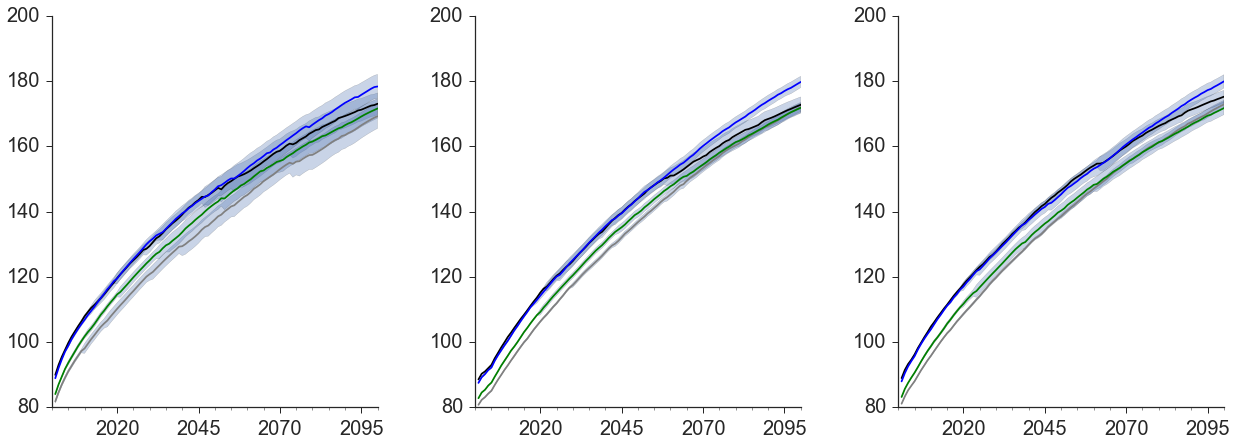

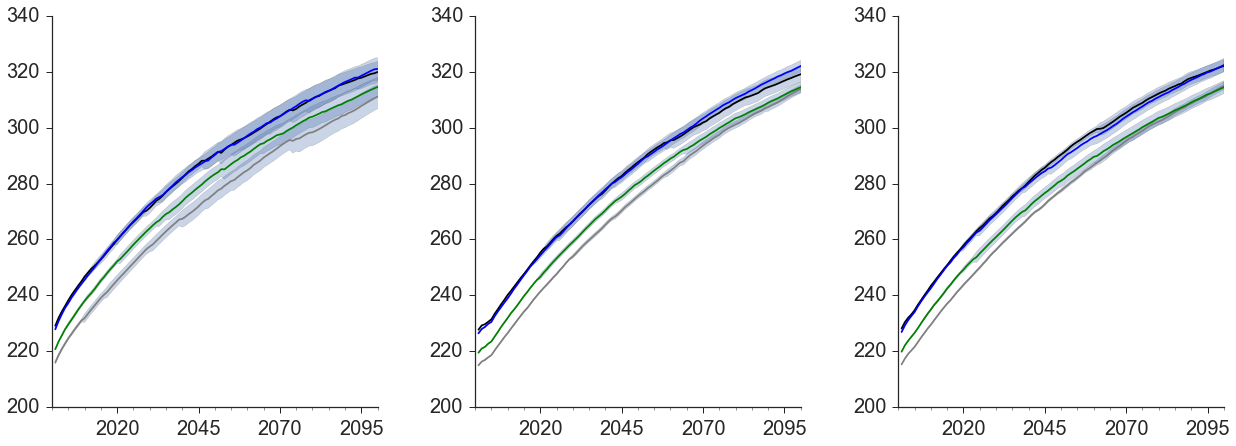

In [162]:
sns.set_style('ticks')
sns.set_context('notebook', font_scale=2)
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(21,7))
plt.subplots_adjust(wspace = 0.3)

plotTS(totSims, 'NOMANCCSM', 'AGBw', 'AGBw_std', ax = ax1, color = 'black')
plotTS(totSims, 'NOMANCNRM','AGBw', 'AGBw_std', ax = ax1, color = 'gray')
plotTS(totSims, 'NOMANFGOALS', 'AGBw', 'AGBw_std', ax = ax1, color = 'green')
plotTS(totSims, 'NOMANMIROC5', 'AGBw', 'AGBw_std', ax = ax1, color = 'blue')

plotTS(totSims, 'OpConCCSM', 'AGBw', 'AGBw_std', ax = ax2, color = 'black')
plotTS(totSims, 'OpConCNRM', 'AGBw', 'AGBw_std', ax = ax2, color = 'gray')
plotTS(totSims, 'OpConFGOALS', 'AGBw', 'AGBw_std', ax = ax2, color = 'green')
plotTS(totSims, 'OpConMIROC5', 'AGBw', 'AGBw_std', ax = ax2, color = 'blue')

plotTS(totSims, 'HSFPCCSM', 'AGBw', 'AGBw_std', ax = ax3, color = 'black')
plotTS(totSims, 'HSFPCNRM', 'AGBw', 'AGBw_std', ax = ax3, color = 'gray')
plotTS(totSims, 'HSFPFGOALS', 'AGBw', 'AGBw_std', ax = ax3, color = 'green')
plotTS(totSims, 'HSFPMIROC5', 'AGBw', 'AGBw_std', ax = ax3, color = 'blue')

sns.despine()

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(21,7))
plt.subplots_adjust(wspace = 0.3)

plotTS(totSims, 'NOMANCCSM', 'TECw', 'TECw_std', ax = ax1, color = 'black')
plotTS(totSims, 'NOMANCNRM','TECw', 'TECw_std', ax = ax1, color = 'gray')
plotTS(totSims, 'NOMANFGOALS', 'TECw', 'TECw_std', ax = ax1, color = 'green')
plotTS(totSims, 'NOMANMIROC5', 'TECw', 'TECw_std', ax = ax1, color = 'blue')

plotTS(totSims, 'OpConCCSM', 'TECw', 'TECw_std', ax = ax2, color = 'black')
plotTS(totSims, 'OpConCNRM', 'TECw', 'TECw_std', ax = ax2, color = 'gray')
plotTS(totSims, 'OpConFGOALS', 'TECw', 'TECw_std', ax = ax2, color = 'green')
plotTS(totSims, 'OpConMIROC5', 'TECw', 'TECw_std', ax = ax2, color = 'blue')

plotTS(totSims, 'HSFPCCSM', 'TECw', 'TECw_std', ax = ax3, color = 'black')
plotTS(totSims, 'HSFPCNRM', 'TECw', 'TECw_std', ax = ax3, color = 'gray')
plotTS(totSims, 'HSFPFGOALS', 'TECw', 'TECw_std', ax = ax3, color = 'green')
plotTS(totSims, 'HSFPMIROC5', 'TECw', 'TECw_std', ax = ax3, color = 'blue')

sns.despine()

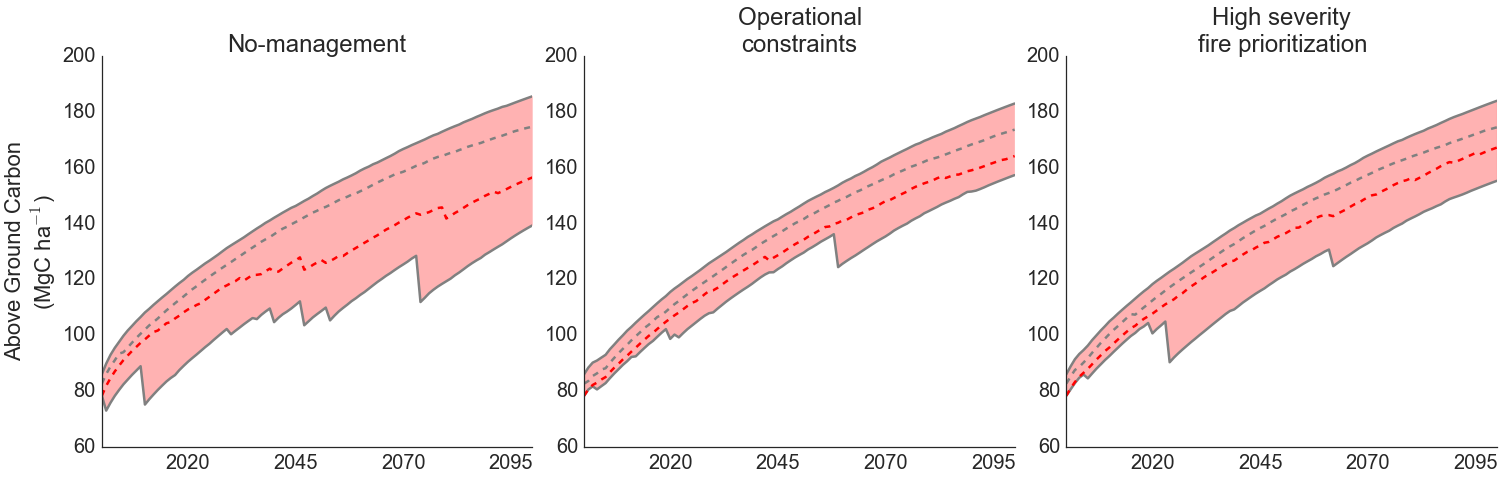

In [157]:
allSims_allReps = appendTreatments(totSimCentDFs)
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(25,7))
plt.subplots_adjust(wspace = 0.12)
sns.set_context('notebook', font_scale=2)

plotAllSimsMinMaxMed(allSims_allReps, 'AGBw', 'No Management', ax = ax1)
plotAllSimsMinMaxMed(allSims_allReps, 'AGBw', 'OpCon', ax = ax2)
test = plotAllSimsMinMaxMed(allSims_allReps, 'AGBw', 'HSFP', ax = ax3)

ax1.set_title('No-management')
ax2.set_title('Operational \nconstraints')
ax3.set_title('High severity \nfire prioritization')

ax1.set_ylabel('Above Ground Carbon \n(MgC ha$^{-1}$)')
sns.despine()
plt.savefig('AGC_Quantiles.tif',dpi=300)

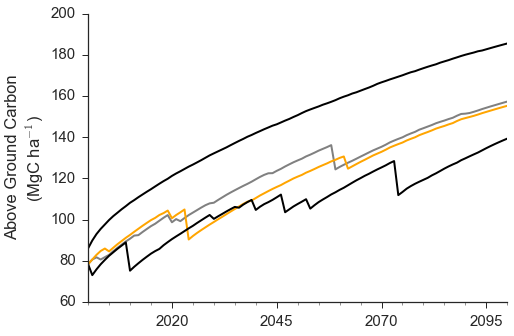

In [203]:
# Generate ecoregion weighted sum    
summed = allSims_allReps.groupby(['Time','rep','Sim','Trtmnt']).sum()

# Reset the index for grouping
reset_summed = summed.reset_index()

NoMgmt = reset_summed[reset_summed.Trtmnt == 'No Management']
OpCon = reset_summed[reset_summed.Trtmnt == 'OpCon']
HSF = reset_summed[reset_summed.Trtmnt == 'HSFP']

# Create the min, max, and median DFs
NoMgmtmax = NoMgmt.groupby('Time').max()
NoMgmtmin = NoMgmt.groupby('Time').min()
NoMgmtmed = NoMgmt.groupby('Time').median()
NoMgmt95 = NoMgmt.groupby('Time').quantile(0.05)

OpConmax = OpCon.groupby('Time').max()
OpConmin = OpCon.groupby('Time').min()
OpConmed = OpCon.groupby('Time').median()
OpCon95 = OpCon.groupby('Time').quantile(0.05)

HSFmax = HSF.groupby('Time').max()
HSFmin = HSF.groupby('Time').min()
HSFmed = HSF.groupby('Time').median()
HSF95 = HSF.groupby('Time').quantile(0.05)

index = pd.date_range('2000-1-1', periods=len(NoMgmtmax), freq='1A')
for df in [NoMgmtmax, NoMgmtmin, OpConmin, 
           HSFmin, OpConmax, HSFmax,
          HSFmed, OpConmed, NoMgmtmed,
          NoMgmt95, OpCon95,HSF95]:
    df.index = index

sns.set_context('notebook',font_scale=1.5)
f, ax1 = plt.subplots(1,1, figsize =(7.5,5))
plt.subplots_adjust(wspace = 0.12)

# Plot lines for min, max, and median
NoMgmtmax['AGBw'].plot(ax = ax1, lw = 2, color = 'black')
OpConmin['AGBw'].plot(ax = ax1, lw = 2, color = 'gray')
HSFmin['AGBw'].plot(ax = ax1, lw = 2, color = 'orange')
NoMgmtmin['AGBw'].plot(ax = ax1, lw = 2, color = 'black')
sns.despine()
sns.set_style('ticks')
ax1.set_ylabel('Above Ground Carbon \n(MgC ha$^{-1}$)')
plt.tight_layout()
plt.savefig('AGC_TRTMNT_COMPARE.tif', dpi = 300)



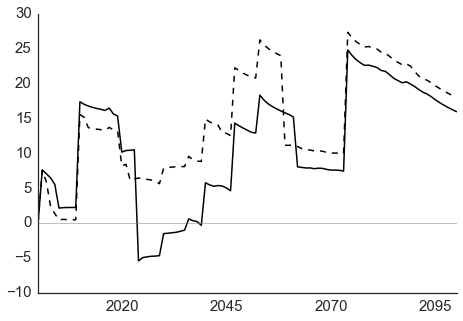

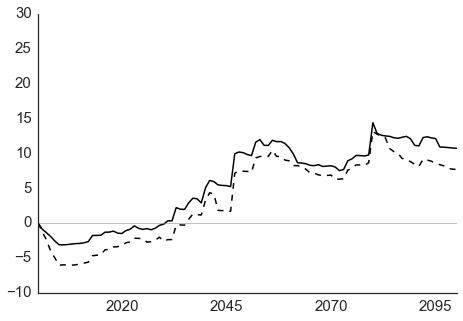

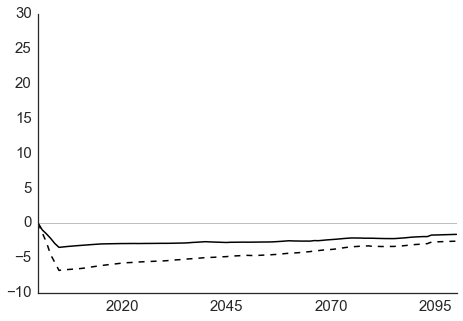

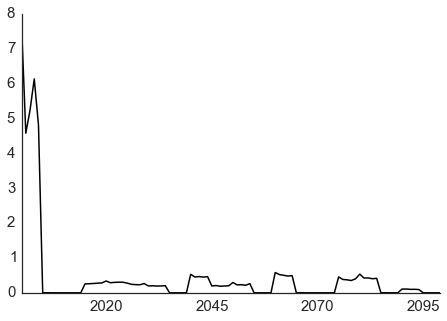

In [324]:
HSFP_diff = HSFmin['AGBw'] - NoMgmtmin['AGBw']
OPCON_diff = OpConmin['AGBw'] - NoMgmtmin['AGBw'] 

HSFPmax_diff = HSFmax['AGBw'] - NoMgmtmax['AGBw']
OPCONmax_diff = OpConmax['AGBw'] - NoMgmtmax['AGBw'] 

HSFP95_diff = HSF95['AGBw'] - NoMgmt95['AGBw']
OPCON95_diff = OpCon95['AGBw'] - NoMgmt95['AGBw'] 

f, ax1 = plt.subplots(1,1, figsize =(7.5,5))
OPCON_diff.plot(ax = ax1, lw = 1.5, linestyle = '--', 
                color = 'black', label = 'Operational Constraint')
HSFP_diff.plot(ax = ax1, lw = 1.5, color = 'black', label = 'HSF Priority')
ax1.axhline(y=0, color='gray', lw = 0.5)

ax1.set_ylim(-10,30)
sns.despine()


f, ax1 = plt.subplots(1,1, figsize =(7.5,5))

OPCON95_diff.plot(ax = ax1, lw = 1.5, linestyle = '--', 
                color = 'black', label = 'Operational Constraint')
HSFP95_diff.plot(ax = ax1, lw = 1.5, color = 'black', label = 'HSF Priority')
ax1.axhline(y=0, color='gray', lw = 0.5)
ax1.set_ylim(-10,30)

sns.despine()

f, ax1 = plt.subplots(1,1, figsize =(7.5,5))

OPCONmax_diff.plot(ax = ax1, lw = 1.5, linestyle = '--', 
                color = 'black', label = 'Operational Constraint')
HSFPmax_diff.plot(ax = ax1, lw = 1.5, color = 'black', label = 'HSF Priority')
ax1.axhline(y=0, color='gray', lw = 0.5)
ax1.set_ylim(-10,30)

sns.despine()

f, ax1 = plt.subplots(1,1, figsize =(7.5,5))

HSFPThinTS_tot.AreaWeightedThin.plot(ax = ax1, lw = 1.5, linestyle = '-', 
                color = 'black', label = 'Operational Constraint')

sns.despine()

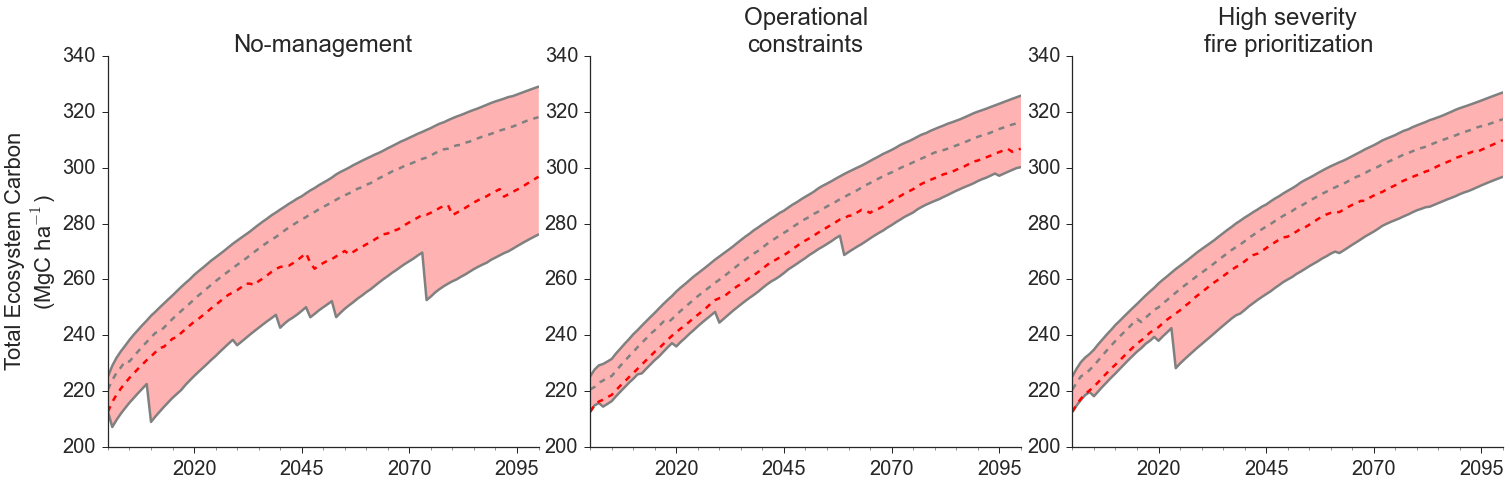

In [440]:
allSims_allReps = appendTreatments(totSimCentDFs)
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(25,7))
plt.subplots_adjust(wspace = 0.12)
sns.set_context('notebook', font_scale=2)

plotAllSimsMinMaxMed(allSims_allReps, 'TECw', 'No Management', ax = ax1)
plotAllSimsMinMaxMed(allSims_allReps, 'TECw', 'OpCon', ax = ax2)
plotAllSimsMinMaxMed(allSims_allReps, 'TECw', 'HSFP', ax = ax3)

ax1.set_title('No-management')
ax2.set_title('Operational \nconstraints')
ax3.set_title('High severity \nfire prioritization')

ax1.set_ylabel('Total Ecosystem Carbon \n(MgC ha$^{-1}$)')
sns.despine()


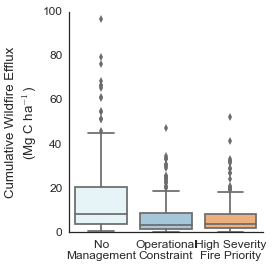

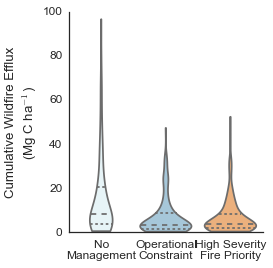

In [154]:
cumulativeReps = appendTreatments(totSums)
TrtmntOrder = ['No Management','OpCon','HSFP']
TrtmntPalette = ['#e5f5f9','#9ecae1','#fdae6b']

fig, ax = plt.subplots(figsize=(4,4))
sns.set_context('notebook', font_scale= 1.2)
FCEplot = sns.boxplot(ax = ax, x="Trtmnt", y="FireCEffluxw", 
                 data=cumulativeReps, order = TrtmntOrder,
                palette = TrtmntPalette)
ax.set_ylabel('Cumulative Wildfire Efflux \n(Mg C ha$^{-1}$)')
ax.set_xlabel('')
ax.set_xticklabels(['No \nManagement','Operational\nConstraint','High Severity\nFire Priority'])
sns.despine()
plt.tight_layout()
plt.savefig('cumulative_fire_emissions.tif',dpi = 300)

TrtmntOrder = ['No Management','OpCon','HSFP']
TrtmntPalette = ['#e5f5f9','#9ecae1','#fdae6b']
fig, ax = plt.subplots(figsize=(4,4))
sns.set_context('notebook', font_scale= 1.2)

FECVio = sns.violinplot(ax = ax, x="Trtmnt", y="FireCEffluxw", 
                    data=cumulativeReps, cut=0, 
                    order = TrtmntOrder, palette = TrtmntPalette,
                   inner="quartile")
ax.set_ylabel('Cumulative Wildfire Efflux \n(Mg C ha$^{-1}$)')
ax.set_xticklabels(['No \nManagement','Operational\nConstraint','High Severity\nFire Priority'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()
plt.savefig('cumulative_fire_emissions_V.tif',dpi = 300)

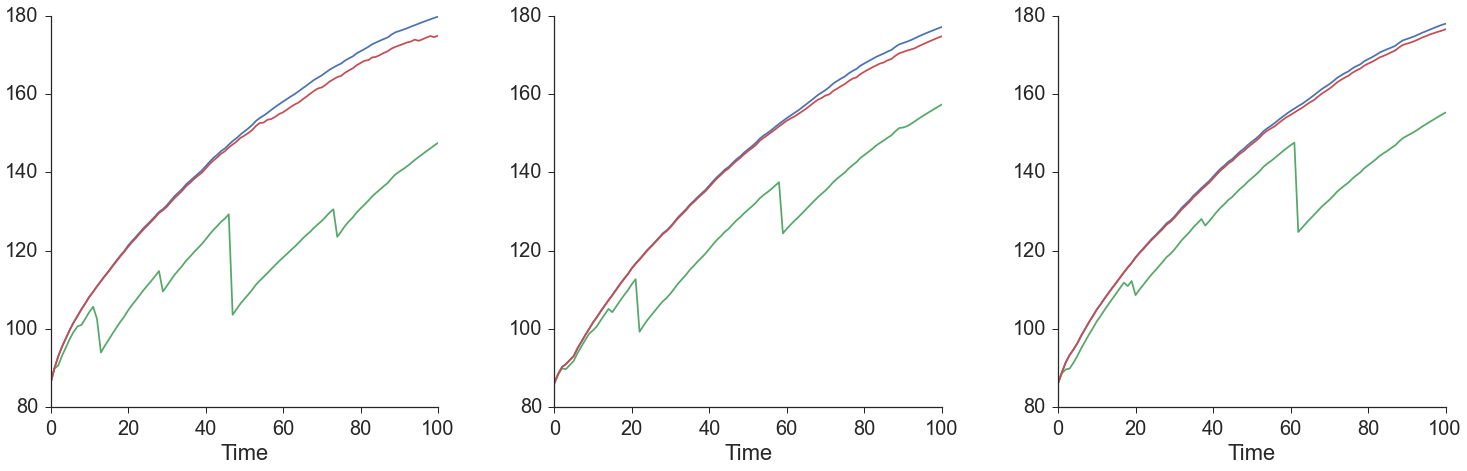

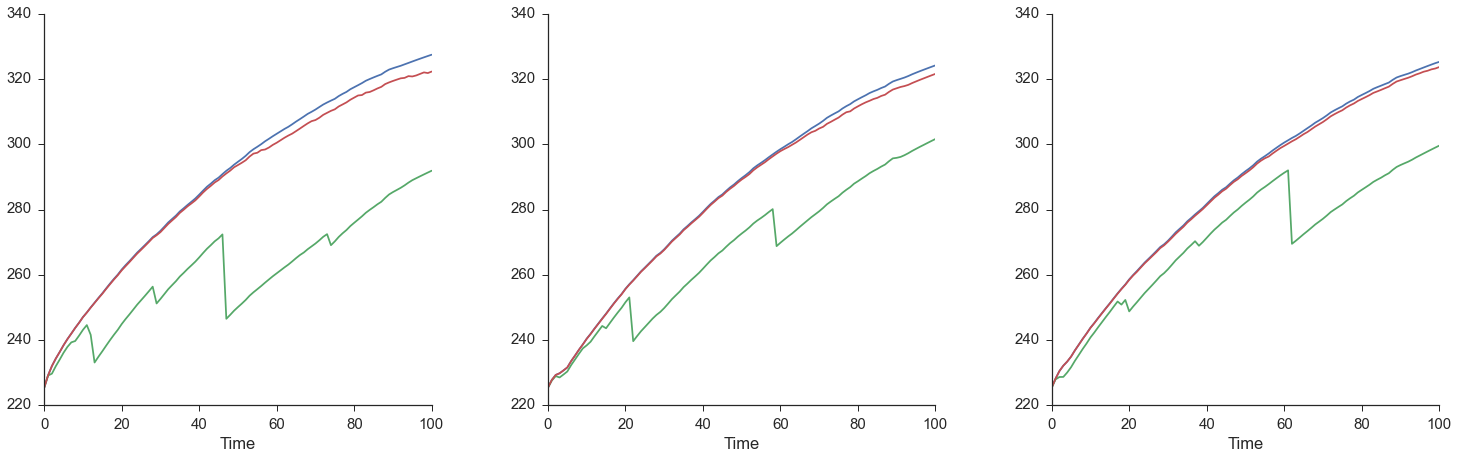

In [292]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(25,7))
plt.subplots_adjust(wspace = 0.3)
sns.set_context('notebook', font_scale=1.5)

plotMinMaxMedReps(simCentNOMANCCSM, 'AGBw', ax = ax1)
plotMinMaxMedReps(simCentOpConCCSM, 'AGBw', ax = ax2)
plotMinMaxMedReps(simCentHSFPCCSM, 'AGBw', ax = ax3)

sns.despine()

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(25,7))
plt.subplots_adjust(wspace = 0.3)
sns.set_context('notebook', font_scale=1.5)

plotMinMaxMedReps(simCentNOMANCCSM, 'TECw', ax = ax1)
plotMinMaxMedReps(simCentOpConCCSM, 'TECw', ax = ax2)
plotMinMaxMedReps(simCentHSFPCCSM, 'TECw', ax = ax3)

sns.despine()

### What was the mean fire severity across all scenarios, by treatment?
Quick mean of the four mean rasters for each climate scenario, by treatment.

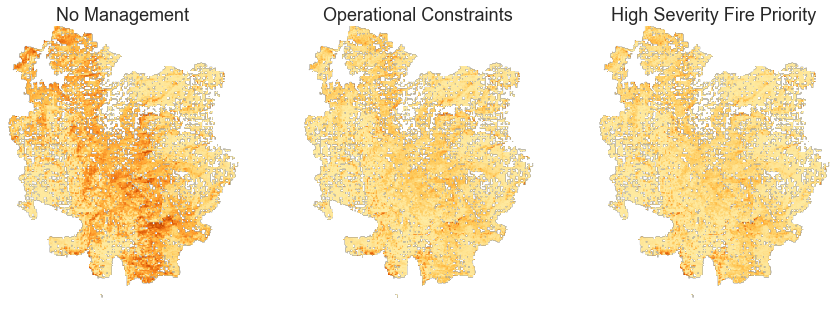

In [109]:
# Take the mean fire severity raster across the 4 climates, by treatment
NoMan_SevList =[sevMapsLowP[4]['ProjClimate_NoMan_CCSM'],sevMapsLowP[5]['ProjClimate_NoMan_CNRM'],
    sevMapsLowP[6]['ProjClimate_NoMan_FGOALS'],sevMapsLowP[7]['ProjClimate_NoMan_MIROC5']]

OpCon_SevList =[sevMapsLowP[8]['ProjClimate_OpCon_CCSM'],sevMapsLowP[9]['ProjClimate_OpCon_CNRM'],
    sevMapsLowP[10]['ProjClimate_OpCon_FGOALS'],sevMapsLowP[11]['ProjClimate_OpCon_MIROC5']]

HSFP_SevList =[sevMapsLowP[0]['ProjClimate_HSFPriority_CCSM'],sevMapsLowP[1]['ProjClimate_HSFPriority_CNRM'],
    sevMapsLowP[2]['ProjClimate_HSFPriority_FGOALS'],sevMapsLowP[3]['ProjClimate_HSFPriority_MIROC5']]

NoMan_SevStack = np.dstack(NoMan_SevList)
NoMan_SevR = np.nanmean(NoMan_SevStack, axis = 2)

OpCon_SevStack = np.dstack(OpCon_SevList)
OpCon_SevR = np.nanmean(OpCon_SevStack, axis = 2)

HSFP_SevStack = np.dstack(HSFP_SevList)
HSFP_SevR = np.nanmean(HSFP_SevStack, axis = 2)

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(15,5))
plotRaster(NoMan_SevR, ax = ax1, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(OpCon_SevR, ax = ax2, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(HSFP_SevR, ax = ax3, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
ax1.set_title('No Management')
ax2.set_title('Operational Constraints')
ax3.set_title('High Severity Fire Priority')
plt.savefig('OpConHSF_Sev_Maps.tif',dpi = 300)

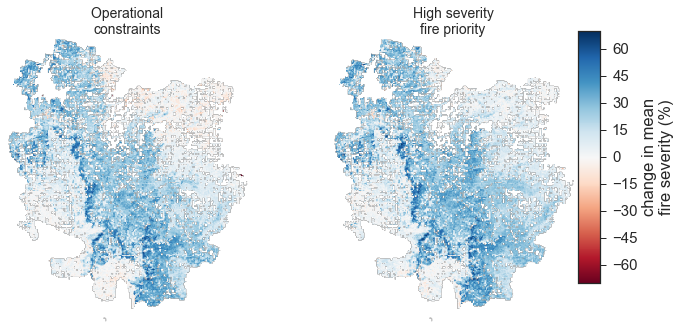

In [212]:
OpCon_Sev_Reduct = ((NoMan_SevR - OpCon_SevR) / NoMan_SevR) * 100
HSFP_Sev_Reduct = ((NoMan_SevR - HSFP_SevR) / NoMan_SevR) * 100

# Plot our hard earned binned severity raster
f,(ax1, ax2) = plt.subplots(1,2, figsize =(10,5))
plt.subplots_adjust(wspace = 0, hspace = 0.1)

sevMap = ax1.imshow(OpCon_Sev_Reduct, cmap = 'RdBu', vmin = -70, vmax = 70)
sevMapS = ax2.imshow(HSFP_Sev_Reduct, cmap = 'RdBu', vmin = -70, vmax = 70)

# Remove the axes
sns.despine()
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

# Add the color bar
cbar_ax = f.add_axes([0.90, 0.18, 0.03, 0.7])
f.colorbar(sevMap, cax=cbar_ax, label = 'change in mean \nfire severity (%)')

# Labels
ax1.set_title('Operational \nconstraints', fontsize = 14)
ax2.set_title('High severity \nfire priority', fontsize = 14)

sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)
plt.tight_layout()
plt.savefig('FireSevReduct.tif',bbox_inches='tight', dpi = 300)

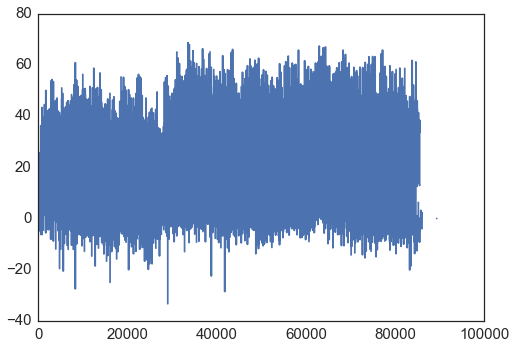

In [214]:
plt.plot(HSFP_Sev_Reduct.ravel())

### Mean fire severity by climate scenario and treatment
This recycles previous raster stacking and severity calculating code -- making sure to only take the mean value of grid cells when fires occurred. Ultimately, this will be displayed as a mean by treatment (across scenario).

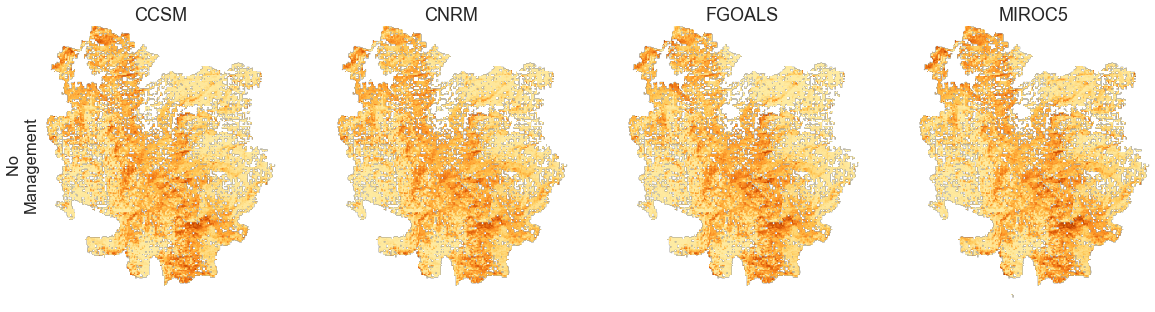

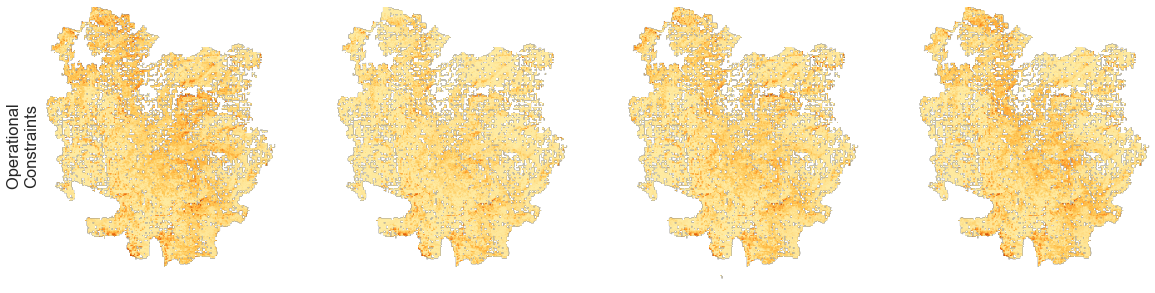

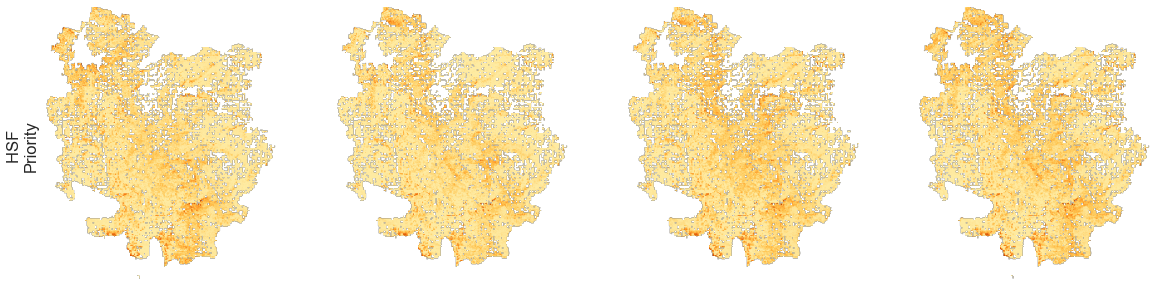

In [108]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
plotRaster(sevMapsLowP[4]['ProjClimate_NoMan_CCSM'], ax= ax1, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevMapsLowP[5]['ProjClimate_NoMan_CNRM'], ax= ax2, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevMapsLowP[6]['ProjClimate_NoMan_FGOALS'], ax= ax3, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevMapsLowP[7]['ProjClimate_NoMan_MIROC5'], ax= ax4, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
ax1.set_title('CCSM')
ax2.set_title('CNRM')
ax3.set_title('FGOALS')
ax4.set_title('MIROC5')
ax1.set_ylabel('No \nManagement')

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
plotRaster(sevMapsLowP[8]['ProjClimate_OpCon_CCSM'], ax= ax1, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevMapsLowP[9]['ProjClimate_OpCon_CNRM'], ax= ax2, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevMapsLowP[10]['ProjClimate_OpCon_FGOALS'], ax= ax3, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevMapsLowP[11]['ProjClimate_OpCon_MIROC5'], ax= ax4, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
ax1.set_ylabel('Operational \nConstraints')

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
plotRaster(sevMapsLowP[0]['ProjClimate_HSFPriority_CCSM'], ax= ax1, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevMapsLowP[1]['ProjClimate_HSFPriority_CNRM'], ax= ax2, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevMapsLowP[2]['ProjClimate_HSFPriority_FGOALS'], ax= ax3, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevMapsLowP[3]['ProjClimate_HSFPriority_MIROC5'], ax= ax4, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
ax1.set_ylabel('HSF \nPriority')


#### Same as above, but for variance

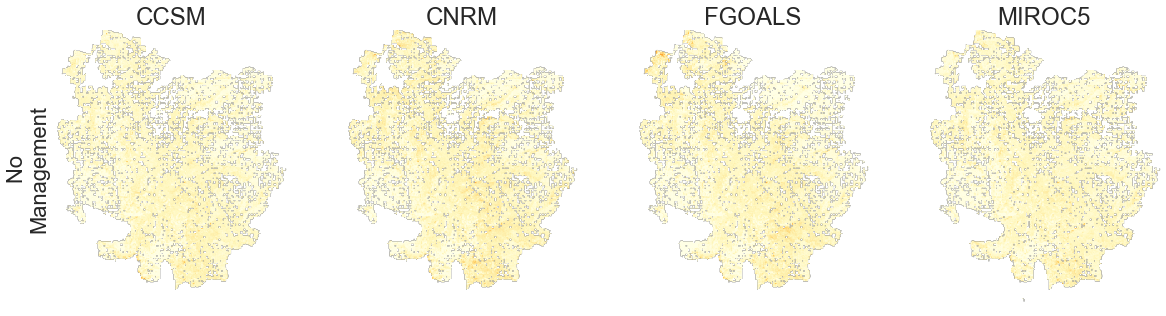

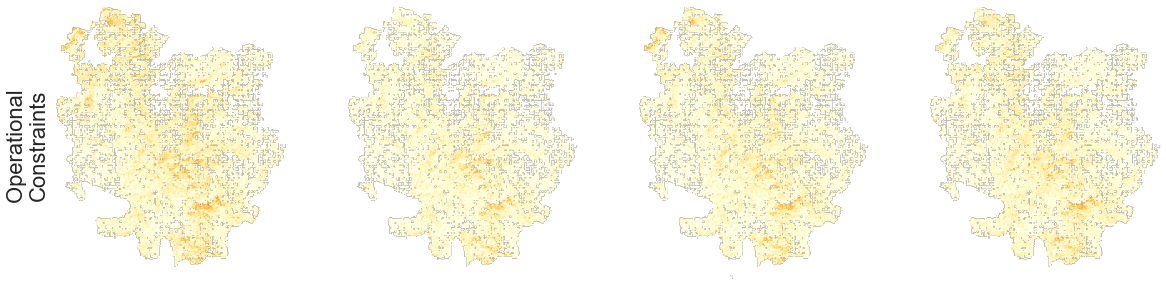

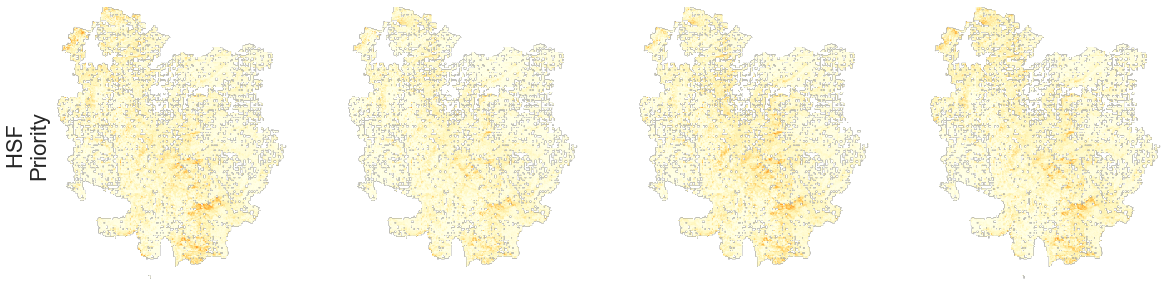

In [164]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
plotRaster(sevVarMapsLowP[4]['ProjClimate_NoMan_CCSM'], ax= ax1, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevVarMapsLowP[5]['ProjClimate_NoMan_CNRM'], ax= ax2, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevVarMapsLowP[6]['ProjClimate_NoMan_FGOALS'], ax= ax3, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevVarMapsLowP[7]['ProjClimate_NoMan_MIROC5'], ax= ax4, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
ax1.set_title('CCSM')
ax2.set_title('CNRM')
ax3.set_title('FGOALS')
ax4.set_title('MIROC5')
ax1.set_ylabel('No \nManagement')

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
plotRaster(sevVarMapsLowP[8]['ProjClimate_OpCon_CCSM'], ax= ax1, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevVarMapsLowP[9]['ProjClimate_OpCon_CNRM'], ax= ax2, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevVarMapsLowP[10]['ProjClimate_OpCon_FGOALS'], ax= ax3, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevVarMapsLowP[11]['ProjClimate_OpCon_MIROC5'], ax= ax4, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
ax1.set_ylabel('Operational \nConstraints')

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
plotRaster(sevVarMapsLowP[0]['ProjClimate_HSFPriority_CCSM'], ax= ax1, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevVarMapsLowP[1]['ProjClimate_HSFPriority_CNRM'], ax= ax2, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevVarMapsLowP[2]['ProjClimate_HSFPriority_FGOALS'], ax= ax3, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
plotRaster(sevVarMapsLowP[3]['ProjClimate_HSFPriority_MIROC5'], ax= ax4, cmap = 'YlOrBr', vmin = 0, vmax = 5 )
ax1.set_ylabel('HSF \nPriority')


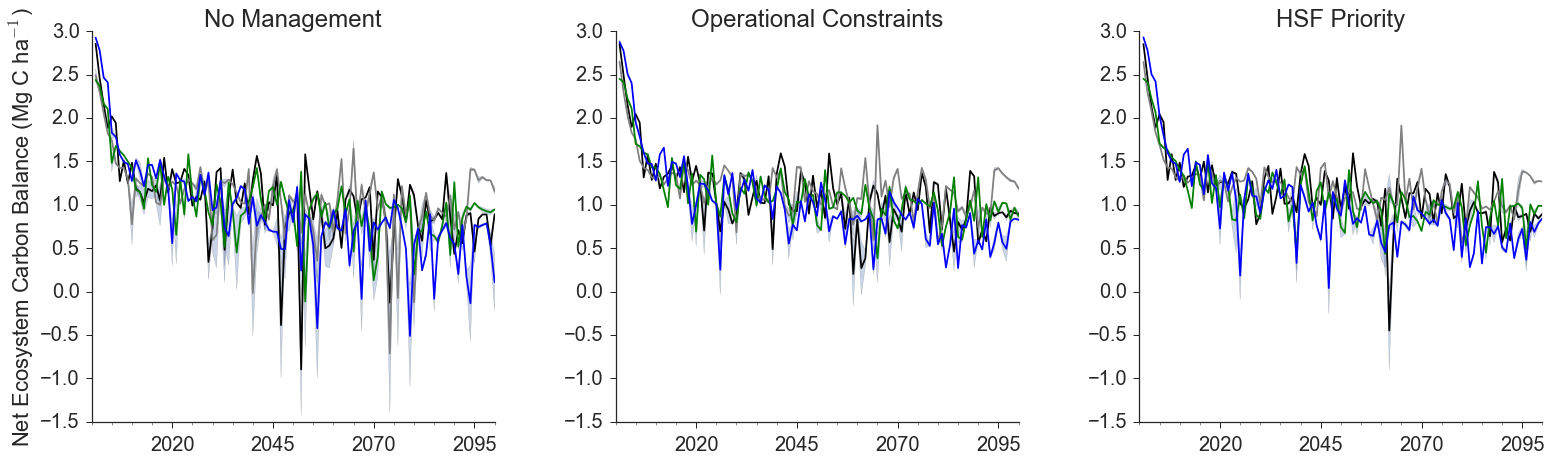

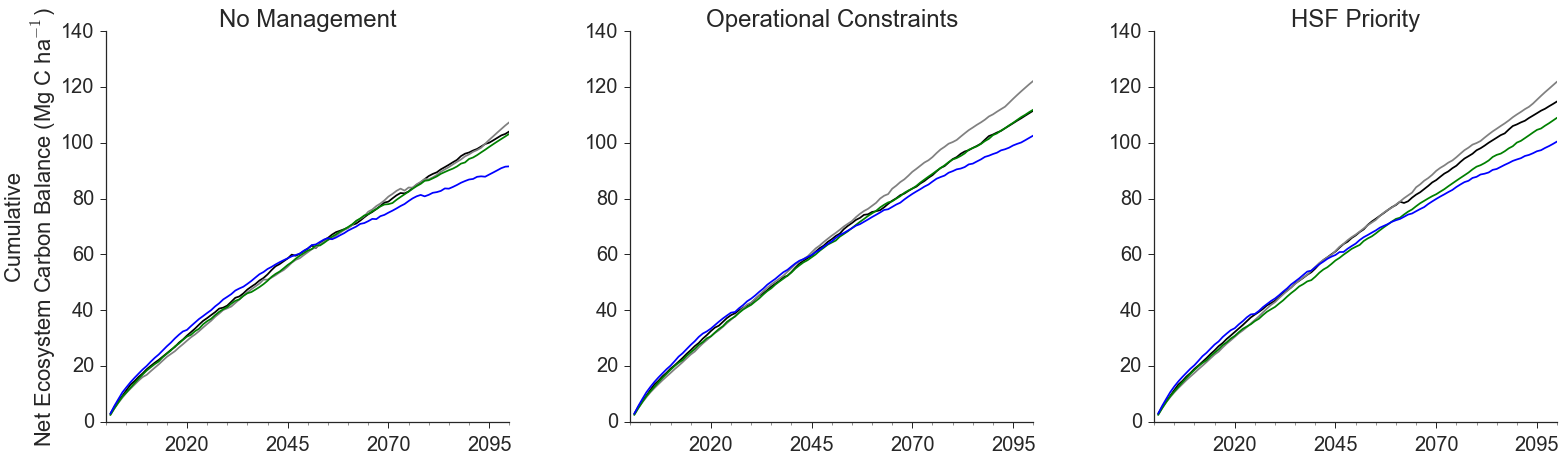

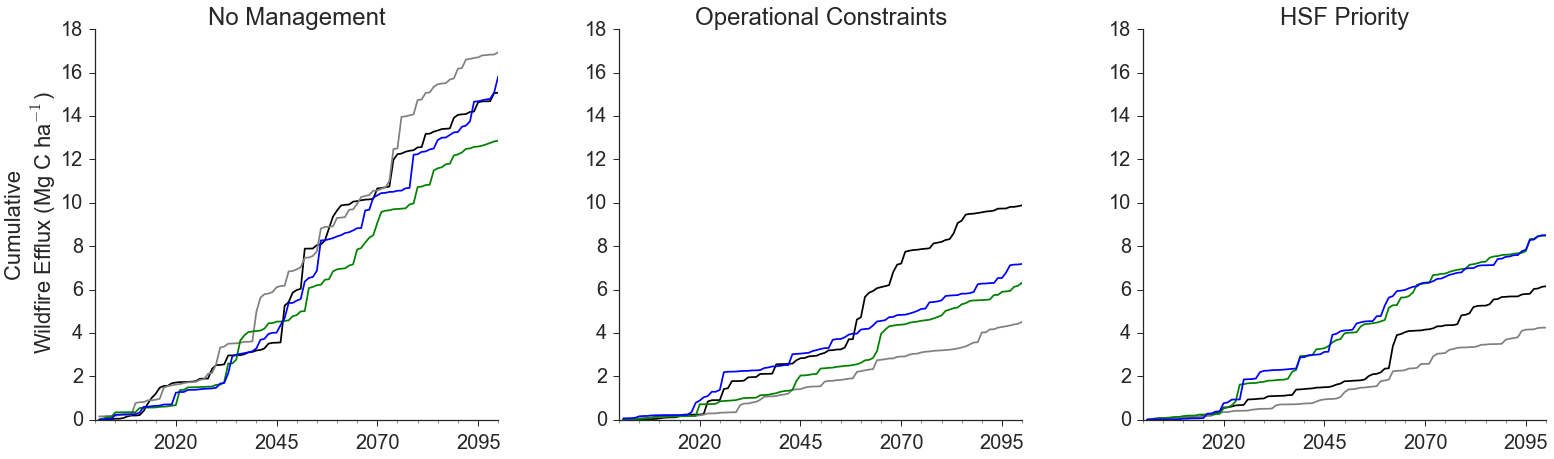

In [165]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(26,7))
plt.subplots_adjust(wspace = 0.3)

plotTS(totSims, 'NOMANCCSM', 'NECBw', 'NECBw_std', ax = ax1, color = 'black')
plotTS(totSims, 'NOMANCNRM','NECBw', 'NECBw_std', ax = ax1, color = 'gray')
plotTS(totSims, 'NOMANFGOALS', 'NECBw', 'NECBw_std', ax = ax1, color = 'green')
plotTS(totSims, 'NOMANMIROC5', 'NECBw', 'NECBw_std', ax = ax1, color = 'blue')

plotTS(totSims, 'OpConCCSM', 'NECBw', 'NECBw_std', ax = ax2, color = 'black')
plotTS(totSims, 'OpConCNRM', 'NECBw', 'NECBw_std', ax = ax2, color = 'gray')
plotTS(totSims, 'OpConFGOALS', 'NECBw', 'NECBw_std', ax = ax2, color = 'green')
plotTS(totSims, 'OpConMIROC5', 'NECBw', 'NECBw_std', ax = ax2, color = 'blue')

plotTS(totSims, 'HSFPCCSM', 'NECBw', 'NECBw_std', ax = ax3, color = 'black')
plotTS(totSims, 'HSFPCNRM', 'NECBw', 'NECBw_std', ax = ax3, color = 'gray')
plotTS(totSims, 'HSFPFGOALS', 'NECBw', 'NECBw_std', ax = ax3, color = 'green')
plotTS(totSims, 'HSFPMIROC5', 'NECBw', 'NECBw_std', ax = ax3, color = 'blue')
ax1.set_title('No Management')
ax2.set_title('Operational Constraints')
ax3.set_title('HSF Priority')
ax1.set_ylabel('Net Ecosystem Carbon Balance (Mg C ha$^{-1}$)')

ax1.set_ylim([-1.5, 3.0])
ax2.set_ylim([-1.5, 3.0])
ax3.set_ylim([-1.5, 3.0])

sns.despine()

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(26,7))
plt.subplots_adjust(wspace = 0.3)

plotTS_cumulative(totSims, 'NOMANCCSM', 'NECBw', ax = ax1, color = 'black')
plotTS_cumulative(totSims, 'NOMANCNRM','NECBw',  ax = ax1, color = 'gray')
plotTS_cumulative(totSims, 'NOMANFGOALS', 'NECBw', ax = ax1, color = 'green')
plotTS_cumulative(totSims, 'NOMANMIROC5', 'NECBw', ax = ax1, color = 'blue')

plotTS_cumulative(totSims, 'OpConCCSM', 'NECBw', ax = ax2, color = 'black')
plotTS_cumulative(totSims, 'OpConCNRM', 'NECBw', ax = ax2, color = 'gray')
plotTS_cumulative(totSims, 'OpConFGOALS', 'NECBw', ax = ax2, color = 'green')
plotTS_cumulative(totSims, 'OpConMIROC5', 'NECBw', ax = ax2, color = 'blue')

plotTS_cumulative(totSims, 'HSFPCCSM', 'NECBw', ax = ax3, color = 'black')
plotTS_cumulative(totSims, 'HSFPCNRM', 'NECBw', ax = ax3, color = 'gray')
plotTS_cumulative(totSims, 'HSFPFGOALS', 'NECBw', ax = ax3, color = 'green')
plotTS_cumulative(totSims, 'HSFPMIROC5', 'NECBw', ax = ax3, color = 'blue')

ax1.set_title('No Management')
ax2.set_title('Operational Constraints')
ax3.set_title('HSF Priority')
ax1.set_ylabel('Cumulative \nNet Ecosystem Carbon Balance (Mg C ha$^{-1}$)')

ax1.set_ylim([0, 140])
ax2.set_ylim([0, 140])
ax3.set_ylim([0, 140])

sns.despine()

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(26,7))
plt.subplots_adjust(wspace = 0.3)

plotTS_cumulative(totSims, 'NOMANCCSM', 'FireCEffluxw', ax = ax1, color = 'black')
plotTS_cumulative(totSims, 'NOMANCNRM','FireCEffluxw',  ax = ax1, color = 'gray')
plotTS_cumulative(totSims, 'NOMANFGOALS', 'FireCEffluxw', ax = ax1, color = 'green')
plotTS_cumulative(totSims, 'NOMANMIROC5', 'FireCEffluxw', ax = ax1, color = 'blue')

plotTS_cumulative(totSims, 'OpConCCSM', 'FireCEffluxw', ax = ax2, color = 'black')
plotTS_cumulative(totSims, 'OpConCNRM', 'FireCEffluxw', ax = ax2, color = 'gray')
plotTS_cumulative(totSims, 'OpConFGOALS', 'FireCEffluxw', ax = ax2, color = 'green')
plotTS_cumulative(totSims, 'OpConMIROC5', 'FireCEffluxw', ax = ax2, color = 'blue')

plotTS_cumulative(totSims, 'HSFPCCSM', 'FireCEffluxw', ax = ax3, color = 'black')
plotTS_cumulative(totSims, 'HSFPCNRM', 'FireCEffluxw', ax = ax3, color = 'gray')
plotTS_cumulative(totSims, 'HSFPFGOALS', 'FireCEffluxw', ax = ax3, color = 'green')
plotTS_cumulative(totSims, 'HSFPMIROC5', 'FireCEffluxw', ax = ax3, color = 'blue')

ax1.set_title('No Management')
ax2.set_title('Operational Constraints')
ax3.set_title('HSF Priority')
ax1.set_ylabel('Cumulative \n Wildfire Efflux (Mg C ha$^{-1}$)')

ax1.set_ylim([0, 18])
ax2.set_ylim([0, 18])
ax3.set_ylim([0, 18])

sns.despine()

In [ ]:
totSims.FireCEffluxw

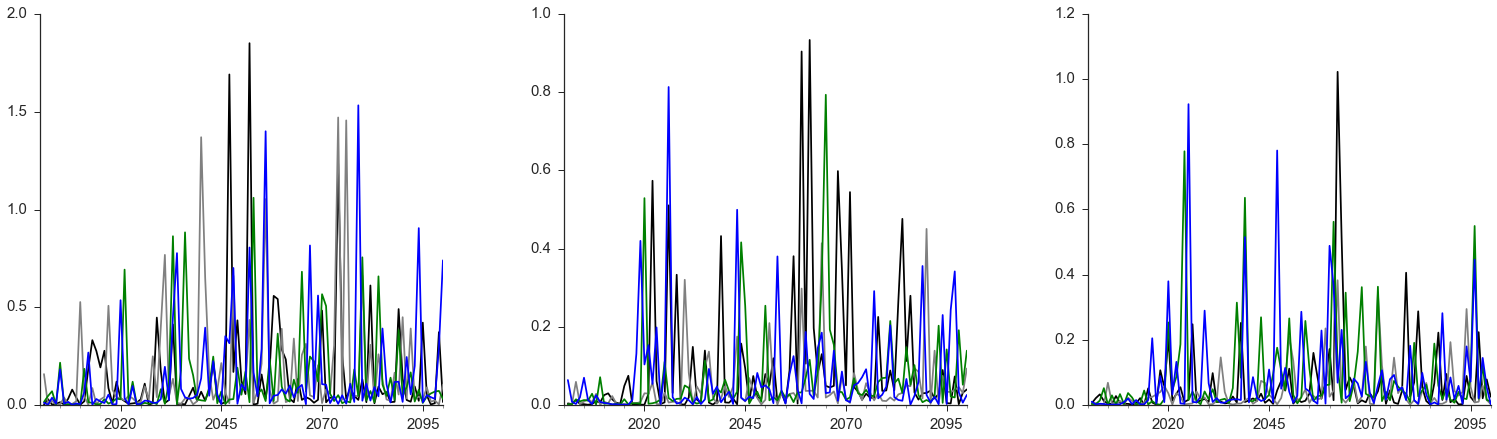

In [206]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(26,7))
plt.subplots_adjust(wspace = 0.3)

plotTS(totSims, 'NOMANCCSM', 'FireCEffluxw', ax = ax1, color = 'black')
plotTS(totSims, 'NOMANCNRM','FireCEffluxw',  ax = ax1, color = 'gray')
plotTS(totSims, 'NOMANFGOALS', 'FireCEffluxw', ax = ax1, color = 'green')
plotTS(totSims, 'NOMANMIROC5', 'FireCEffluxw', ax = ax1, color = 'blue')

plotTS(totSims, 'OpConCCSM', 'FireCEffluxw', ax = ax2, color = 'black')
plotTS(totSims, 'OpConCNRM', 'FireCEffluxw',  ax = ax2, color = 'gray')
plotTS(totSims, 'OpConFGOALS', 'FireCEffluxw', ax = ax2, color = 'green')
plotTS(totSims, 'OpConMIROC5', 'FireCEffluxw', ax = ax2, color = 'blue')

plotTS(totSims, 'HSFPCCSM', 'FireCEffluxw', ax = ax3, color = 'black')
plotTS(totSims, 'HSFPCNRM', 'FireCEffluxw', ax = ax3, color = 'gray')
plotTS(totSims, 'HSFPFGOALS', 'FireCEffluxw', ax = ax3, color = 'green')
plotTS(totSims, 'HSFPMIROC5', 'FireCEffluxw', ax = ax3, color = 'blue')
sns.despine()


In [48]:
idx = 0
for simName in projClimNames:
    print dataDir + simName
    sevrasters = severityStack(dataDir + simName, 100)
    numIters = np.arange(0,5000)
    sevArray = []
    for iteration in numIters:
        sevArray.append(sevrasters[iteration].ravel())
    combinedArray = np.concatenate( sevArray, axis=0 )
    combinedArray = combinedArray - 2
    sev1 = combinedArray[combinedArray == 1].size
    sev2 = combinedArray[combinedArray == 2].size
    sev3 = combinedArray[combinedArray == 3].size
    sev4 = combinedArray[combinedArray == 4].size
    sev5 = combinedArray[combinedArray == 5].size
    if idx == 0:
        simSev = pd.DataFrame(dict(sim = simName, 
                            SEV1 = sev1, SEV2 = sev2, 
                            SEV3 = sev3, SEV4 = sev4, 
                            SEV5 = sev5), index = [idx])
    else:
        tempSev = pd.DataFrame(dict(sim = simName, 
                            SEV1 = sev1, SEV2 = sev2, 
                            SEV3 = sev3, SEV4 = sev4, 
                            SEV5 = sev5), index = [idx])
        simSev = pd.concat([simSev, tempSev])
    idx +=1


Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CCSM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CNRM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_FGOALS
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_MIROC5
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_NoMan_CCSM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_NoMan_CNRM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_NoMan_FGOALS
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_NoMan_MIROC5
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_OpCon_CCSM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_OpCon_CNRM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_OpCon_FGOALS
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_OpCon_MIROC5


In [60]:
warnings.filterwarnings("ignore")
simSev['Trtmnt'] = 'NA'
simSev['Trtmnt'][0] = 'HSF Priority'
simSev['Trtmnt'][1] = 'HSF Priority'
simSev['Trtmnt'][2] = 'HSF Priority'
simSev['Trtmnt'][3] = 'HSF Priority'
simSev['Trtmnt'][4] = 'No Management'
simSev['Trtmnt'][5] = 'No Management'
simSev['Trtmnt'][6] = 'No Management'
simSev['Trtmnt'][7] = 'No Management'
simSev['Trtmnt'][8] = 'Operational Constraints'
simSev['Trtmnt'][9] = 'Operational Constraints'
simSev['Trtmnt'][10] = 'Operational Constraints'
simSev['Trtmnt'][11] = 'Operational Constraints'

simSev['Climate'] = 'NA'
simSev['Climate'][0] = 'CCSM'
simSev['Climate'][1] = 'CNRM'
simSev['Climate'][2] = 'FGOALS'
simSev['Climate'][3] = 'MIROC5'
simSev['Climate'][4] = 'CCSM'
simSev['Climate'][5] = 'CNRM'
simSev['Climate'][6] = 'FGOALS'
simSev['Climate'][7] = 'MIROC5'
simSev['Climate'][8] = 'CCSM'
simSev['Climate'][9] = 'CNRM'
simSev['Climate'][10] = 'FGOALS'
simSev['Climate'][11] = 'MIROC5'


firesSev_m = pd.melt(simSev, id_vars=['sim','Trtmnt','Climate'])
warnings.filterwarnings("default")

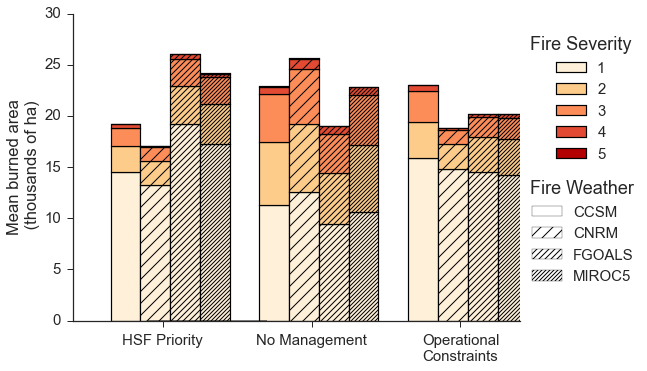

In [82]:
df1 = simSev[simSev.Climate == 'CCSM']
df2 = simSev[simSev.Climate == 'CNRM']
df3 = simSev[simSev.Climate == 'FGOALS']
df4 = simSev[simSev.Climate == 'MIROC5']

del df1['sim']
del df1['Trtmnt']
del df1['Climate']

del df2['sim']
del df2['Trtmnt']
del df2['Climate']

del df3['sim']
del df3['Trtmnt']
del df3['Climate']

del df4['sim']
del df4['Trtmnt']
del df4['Climate']

df1 = df1 / (1000 * 50)
df2 = df2 / (1000 * 50)
df3 = df3 / (1000 * 50)
df4 = df4 / (1000 * 50)

df1.columns = ['1','2','3','4','5']
df2.columns = ['1','2','3','4','5']
df3.columns = ['1','2','3','4','5']
df4.columns = ['1','2','3','4','5']

sns.set_context('notebook', font_scale=1.5)
gg= plot_clustered_stacked([df1, df2, df3, df4],["CCSM", "CNRM","FGOALS", "MIROC5"], 
                           color = ['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000'],
                            H="//")
sns.despine()
gg.set_xticklabels(['HSF Priority','No Management', 
                    'Operational\nConstraints'], rotation = 0)
gg.set_ylabel('Mean burned area\n (thousands of ha)')
gg.set_title('')

In [175]:
# Create simple plot of cumulative area burned by treatment and climate
simSev

SEV1    SEV2    SEV3   SEV4  SEV5                             sim  \
0   725742  128354   87155  17952   929    ProjClimate_HSFPriority_CCSM   
1   661395  117881   67131   9165   239    ProjClimate_HSFPriority_CNRM   
2   963088  183669  130572  24226  1073  ProjClimate_HSFPriority_FGOALS   
3   862629  197518  128163  19330   484  ProjClimate_HSFPriority_MIROC5   
4   566311  308457  230818  37856  1551          ProjClimate_NoMan_CCSM   
5   629533  331340  267212  52158  2474          ProjClimate_NoMan_CNRM   
6   472097  247306  194730  37158  1796        ProjClimate_NoMan_FGOALS   
7   531327  325275  244648  38924  1754        ProjClimate_NoMan_MIROC5   
8   794231  177202  149926  28683  1268          ProjClimate_OpCon_CCSM   
9   739564  123011   67564  11678   447          ProjClimate_OpCon_CNRM   
10  727110  169902   97457  13929   402        ProjClimate_OpCon_FGOALS   
11  709748  175641  106560  18094   721        ProjClimate_OpCon_MIROC5   

                     Trtmnt Climate  
0              HSF Priority    CCSM  
1              HSF Priority    CNRM  
2              HSF Priority  FGOALS  
3              HSF Priority  MIROC5  
4             No Management    CCSM  
5             No Management    CNRM  
6             No Management  FGOALS  
7             No Management  MIROC5  
8   Operational Constraints    CCSM  
9   Operational Constraints    CNRM  
10  Operational Constraints  FGOALS  
11  Operational Constraints  MIROC5

In [88]:
print 'No Management: CCSM -             ' + str(np.count_nonzero(sevMapsLowP[4][projClimNames[4]].ravel() > 3))
print 'No Management: CNRM -             ' + str(np.count_nonzero(sevMapsLowP[5][projClimNames[5]].ravel() > 3))
print 'No Management: FGOALS -           ' + str(np.count_nonzero(sevMapsLowP[6][projClimNames[6]].ravel() > 3))
print 'No Management: MIROC5 -           ' + str(np.count_nonzero(sevMapsLowP[7][projClimNames[7]].ravel() > 3))

print 'Operational Constraints: CCSM -   ' + str( np.count_nonzero(sevMapsLowP[8][projClimNames[8]].ravel() > 3))
print 'Operational Constraints: CNRM -   ' + str( np.count_nonzero(sevMapsLowP[9][projClimNames[9]].ravel() > 3))
print 'Operational Constraints: FGOALS - ' + str( np.count_nonzero(sevMapsLowP[10][projClimNames[10]].ravel() > 3))
print 'Operational Constraints: MIROC5 - ' + str( np.count_nonzero(sevMapsLowP[11][projClimNames[11]].ravel() > 3))

print 'HSF Priority: CCSM -              ' + str( np.count_nonzero(sevMapsLowP[0][projClimNames[0]].ravel() > 3))
print 'HSF Priority: CNRM -              ' + str( np.count_nonzero(sevMapsLowP[1][projClimNames[1]].ravel() > 3))
print 'HSF Priority: FGOALS -            ' + str( np.count_nonzero(sevMapsLowP[2][projClimNames[2]].ravel() > 3))
print 'HSF Priority: MIROC5 -            ' + str( np.count_nonzero(sevMapsLowP[3][projClimNames[3]].ravel() > 3))

No Management: CCSM -             1483
No Management: CNRM -             1103
No Management: FGOALS -           1355
No Management: MIROC5 -           1649
Operational Constraints: CCSM -   242
Operational Constraints: CNRM -   88
Operational Constraints: FGOALS - 157
Operational Constraints: MIROC5 - 139
HSF Priority: CCSM -              115
HSF Priority: CNRM -              75
HSF Priority: FGOALS -            134
HSF Priority: MIROC5 -            162


In [95]:
import warnings # I know its bad practice ... 
warnings.filterwarnings('ignore')

totSums['SEV'] = 'NULL'
totSums.SEV[totSums.Sim == 'HSFPCCSM'] = 'HFSP'
totSums.SEV[totSums.Sim == 'HSFPCNRM'] = 'HFSP'
totSums.SEV[totSums.Sim == 'HSFPFGOALS'] = 'HFSP'
totSums.SEV[totSums.Sim == 'HSFPMIROC5'] = 'HFSP'
totSums.SEV[totSums.Sim == 'NOMANCCSM'] = 'NoMan'
totSums.SEV[totSums.Sim == 'NOMANCNRM'] = 'NoMan'
totSums.SEV[totSums.Sim == 'NOMANFGOALS'] = 'NoMan'
totSums.SEV[totSums.Sim == 'NOMANMIROC5'] = 'NoMan'
totSums.SEV[totSums.Sim == 'OpConCCSM'] = 'OpCon'
totSums.SEV[totSums.Sim == 'OpConCNRM'] = 'OpCon'
totSums.SEV[totSums.Sim == 'OpConFGOALS'] = 'OpCon'
totSums.SEV[totSums.Sim == 'OpConMIROC5'] = 'OpCon'

simsHSFP = totSums[totSums.SEV == 'HFSP']
simsNoMan = totSums[totSums.SEV == 'NoMan']
simsOpCon = totSums[totSums.SEV == 'OpCon']

warnings.filterwarnings('default')

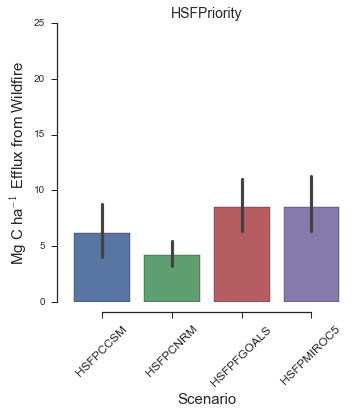

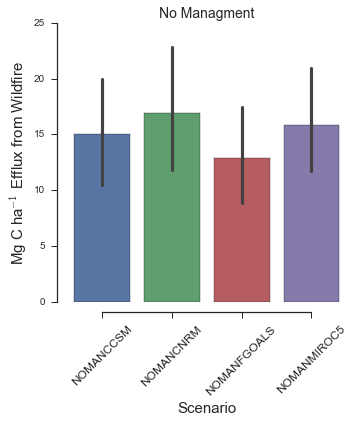

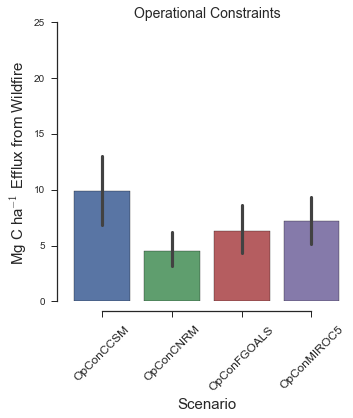

In [166]:
f = plt.figure(figsize=(5,5))
fig = sns.barplot(x = 'Sim', y = 'FireCEffluxw', data = simsHSFP)
sns.set_context('notebook')
axes = fig.axes
plt.ylim([0,25])
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Mg C ha$^{-1}$ Efflux from Wildfire', fontsize = 15)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=45, fontsize = 12)
plt.title('HSFPriority', fontsize = 14)

f = plt.figure(figsize=(5,5))
fig = sns.barplot(x = 'Sim', y = 'FireCEffluxw', data = simsNoMan)
sns.set_context('notebook')
axes = fig.axes
plt.ylim([0,25])

axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Mg C ha$^{-1}$ Efflux from Wildfire', fontsize = 15)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=45, fontsize = 12)
plt.title('No Managment', fontsize = 14)


f = plt.figure(figsize=(5,5))
fig = sns.barplot(x = 'Sim', y = 'FireCEffluxw', data = simsOpCon)
sns.set_context('notebook')
plt.ylim([0,25])
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Mg C ha$^{-1}$ Efflux from Wildfire', fontsize = 15)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=45, fontsize = 12)
plt.title('Operational Constraints', fontsize = 14)


In [99]:
thinMapsLowP = []
thinVarMapsLowP = []
thinCountMapsLowP = []

for sim in mgmtNames:
    print dataDir + sim
    thinrasters,thinrastersTO,thinrastersRX = thinStack(dataDir + sim, 100)
    thinCOUNT, thinSUM, thinVAR = thinGen(thinrasters)
    thinmap = {sim : thinSUM}
    thinvarmap = {sim : thinVAR}
    thincountmap = {sim : thinCOUNT}
    
    thinOnlyCOUNT, thinOnlySUM, thinOnlyVAR = thinGen(thinrastersTO)
    thinOmap = {sim : thinOnlySUM}
    thinOvarmap = {sim : thinOnlyVAR}
    thinOcountmap = {sim : thinOnlyCOUNT}

    # list of dicts for all biomass removal
    thinMapsLowP.append(thinmap)
    thinVarMapsLowP.append(thinvarmap)
    thinCountMapsLowP.append(thincountmap)
    
# Replace 0 values with NaN for visualization purposes    
idx = 0
for MGMTSIM in mgmtNames:
    thinMapsLowP[idx][MGMTSIM][thinMapsLowP[idx][MGMTSIM] == 0] = np.nan
    idx += 1

Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CCSM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CNRM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_FGOALS
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_MIROC5
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_OpCon_CCSM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_OpCon_CNRM
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_OpCon_FGOALS
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_OpCon_MIROC5


C:\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [101]:
idx = 0
for MGMTSIM in mgmtNames:
    thinMapsLowP[idx][MGMTSIM][thinMapsLowP[idx][MGMTSIM] == 0] = np.nan
    idx += 1

HSFP CCSM: 532113.137
HSFP CNRM: 497893.47
HSFP FGOALS: 501183.2732
HSFP MIROC5: 517832.806
OpCOn CCSM: 867841.294
OpCOn CNRM: 799519.1808
OpCOn FGOALS: 817483.1866
OpCOn MIROC5: 854424.0456


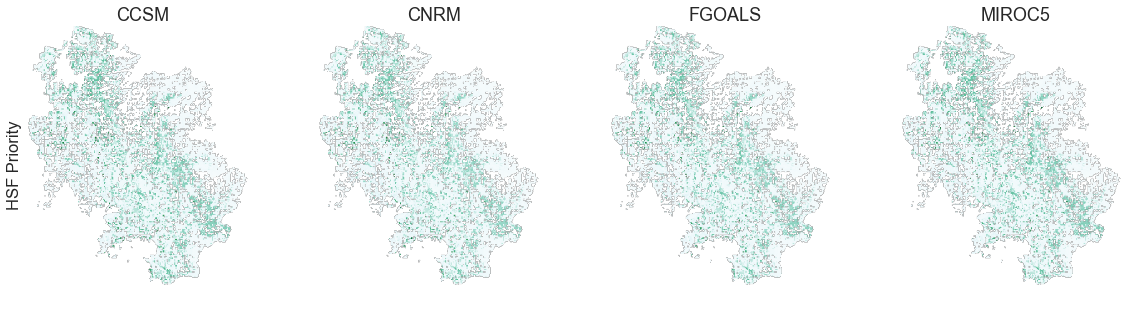

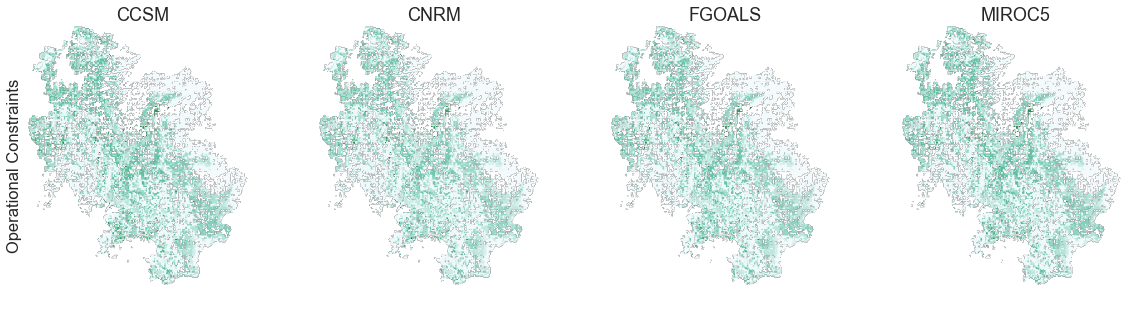

In [102]:
sns.set_context('notebook', font_scale=1.5)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
plotRaster(thinMapsLowP[0]['ProjClimate_HSFPriority_CCSM'] * ((0.01) / 50), 
           ax= ax1, cmap = 'BuGn', vmin = 0, vmax = 120)
plotRaster(thinMapsLowP[1]['ProjClimate_HSFPriority_CNRM'] * ((0.01) / 50), 
           ax= ax2, cmap = 'BuGn', vmin = 0, vmax = 120)
plotRaster(thinMapsLowP[2]['ProjClimate_HSFPriority_FGOALS'] * ((0.01) / 50), 
           ax= ax3, cmap = 'BuGn', vmin = 0, vmax = 120)
plotRaster(thinMapsLowP[3]['ProjClimate_HSFPriority_MIROC5'] * ((0.01) / 50), 
           ax= ax4, cmap = 'BuGn', vmin = 0, vmax = 120)
ax1.set_title('CCSM')
ax2.set_title('CNRM')
ax3.set_title('FGOALS')
ax4.set_title('MIROC5')
ax1.set_ylabel('HSF Priority')

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
plotRaster(thinMapsLowP[4]['ProjClimate_OpCon_CCSM'] * ((0.01) / 50), 
           ax= ax1, cmap = 'BuGn', vmin = 0, vmax = 120)
plotRaster(thinMapsLowP[5]['ProjClimate_OpCon_CNRM'] * ((0.01) / 50), 
           ax= ax2, cmap = 'BuGn', vmin = 0, vmax = 120)
plotRaster(thinMapsLowP[6]['ProjClimate_OpCon_FGOALS'] * ((0.01) / 50), 
           ax= ax3, cmap = 'BuGn', vmin = 0, vmax = 120)
plotRaster(thinMapsLowP[7]['ProjClimate_OpCon_MIROC5'] * ((0.01) / 50), 
           ax= ax4, cmap = 'BuGn', vmin = 0, vmax = 120)
ax1.set_title('CCSM')
ax2.set_title('CNRM')
ax3.set_title('FGOALS')
ax4.set_title('MIROC5')
ax1.set_ylabel('Operational Constraints')

print 'HSFP CCSM: ' + str(np.nansum(thinMapsLowP[0]['ProjClimate_HSFPriority_CCSM'] * ((0.01) / 50)))
print 'HSFP CNRM: ' + str(np.nansum(thinMapsLowP[1]['ProjClimate_HSFPriority_CNRM'] * ((0.01) / 50)))
print 'HSFP FGOALS: ' + str(np.nansum(thinMapsLowP[2]['ProjClimate_HSFPriority_FGOALS'] * ((0.01) / 50)))
print 'HSFP MIROC5: ' + str(np.nansum(thinMapsLowP[3]['ProjClimate_HSFPriority_MIROC5'] * ((0.01) / 50)))

print 'OpCOn CCSM: ' + str(np.nansum(thinMapsLowP[4]['ProjClimate_OpCon_CCSM'] * ((0.01) / 50)))
print 'OpCOn CNRM: ' + str(np.nansum(thinMapsLowP[5]['ProjClimate_OpCon_CNRM'] * ((0.01) / 50)))
print 'OpCOn FGOALS: ' + str(np.nansum(thinMapsLowP[6]['ProjClimate_OpCon_FGOALS'] * ((0.01) / 50)))
print 'OpCOn MIROC5: ' + str(np.nansum(thinMapsLowP[7]['ProjClimate_OpCon_MIROC5'] * ((0.01) / 50)))


### Calculate the mean total biomass harvest by treatment
We need to take the mean total biomass removed for all four climate scenarios, by treatment. This map we can further break up into Thinning and RxFire using the thin logs, and by making  box plots (or bars if theres no variability between runs).

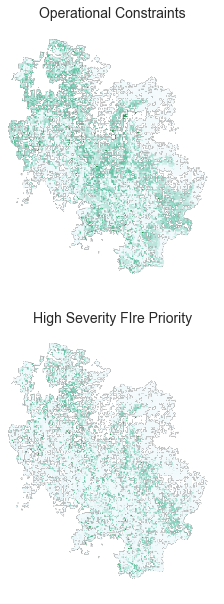

In [105]:
# Take the mean thin raster across the 4 climates, by treatment
OpCon_ThinList =[thinMapsLowP[4]['ProjClimate_OpCon_CCSM'],thinMapsLowP[5]['ProjClimate_OpCon_CNRM'],
    thinMapsLowP[6]['ProjClimate_OpCon_FGOALS'],thinMapsLowP[7]['ProjClimate_OpCon_MIROC5']]

HSFP_ThinList =[thinMapsLowP[0]['ProjClimate_HSFPriority_CCSM'],thinMapsLowP[1]['ProjClimate_HSFPriority_CNRM'],
    thinMapsLowP[2]['ProjClimate_HSFPriority_FGOALS'],thinMapsLowP[3]['ProjClimate_HSFPriority_MIROC5']]

OpCon_ThinStack = np.dstack(OpCon_ThinList)
OpCon_ThinR = np.nanmean(OpCon_ThinStack, axis = 2)

HSFP_ThinStack = np.dstack(HSFP_ThinList)
HSFP_ThinR = np.nanmean(HSFP_ThinStack, axis = 2)

f, ((ax1), (ax2)) = plt.subplots(2,1, figsize =(5,10))
plotRaster(OpCon_ThinR * (0.01) / 50, ax = ax1, cmap = 'BuGn', vmin = 0, vmax = 120)
plotRaster(HSFP_ThinR  * (0.01) / 50, ax = ax2, cmap = 'BuGn', vmin = 0, vmax = 120)

ax1.set_title('Operational Constraints\n', fontsize = 14)
ax2.set_title('High Severity FIre Priority\n', fontsize = 14)
plt.savefig('Biomass_Removed_By_Treatment.tif', dpi = 300)

### We want to put some box plots next to the maps above
But first we have to gather the data to populate those plots -- this requires reading some thin log data. This step is horribly optimized, and takes long and longer the more thin logs that it concatenates. For now I'm reading in 5 reps of each sim, and think ultimately I need to save the variable of 50 reps by scenario and climate, then concatenate them after the fact.

In [11]:
### ***** This is a time consuming step ***** ###
thinLog = 'log.csv'

counter = 0
for simname in mgmtNames:
    num_replicates = len(next(os.walk(dataDir + simname))[1])
    #reps = np.arange(1,num_replicates+1,1)
    reps = np.arange(1,6,1)
    for rep in reps:
        wkDir_c = dataDir + simname + '/replicate' + str(rep) + '/Thin/'
        print wkDir_c
        if counter == 0:
            tlogTot = pd.read_csv(wkDir_c + thinLog)
            tlogTot['SIM'] = simname
            tlogTot['REP'] = rep
        else:           
            tlog = pd.read_csv(wkDir_c + thinLog)
            tlog['SIM'] = simname
            tlog['REP'] = rep
            tlogTot = pd.concat([tlogTot, tlog])
        counter = counter + 1



Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CCSM/replicate1/Thin/
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CCSM/replicate2/Thin/
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CCSM/replicate3/Thin/
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CCSM/replicate4/Thin/
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CCSM/replicate5/Thin/
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CNRM/replicate1/Thin/
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CNRM/replicate2/Thin/
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CNRM/replicate3/Thin/
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CNRM/replicate4/Thin/
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_CNRM/replicate5/Thin/
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_HSFPriority_FGOALS/replicate1/Thin/
Y:/DanK/DinkeyCreek/ProjectedClimate_MS/ProjClimate_

In [26]:
import warnings # I know its bad practice ... 
warnings.filterwarnings('ignore')

tlogTot['TRTMNT'] = 'NULL'
tlogTot.TRTMNT[tlogTot.SIM == 'ProjClimate_HSFPriority_CCSM'] = 'HFSP'
tlogTot.TRTMNT[tlogTot.SIM == 'ProjClimate_HSFPriority_CNRM'] = 'HFSP'
tlogTot.TRTMNT[tlogTot.SIM == 'ProjClimate_HSFPriority_FGOALS'] = 'HFSP'
tlogTot.TRTMNT[tlogTot.SIM == 'ProjClimate_HSFPriority_MIROC5'] = 'HFSP'
tlogTot.TRTMNT[tlogTot.SIM == 'ProjClimate_OpCon_CCSM'] = 'OpCon'
tlogTot.TRTMNT[tlogTot.SIM == 'ProjClimate_OpCon_CNRM'] = 'OpCon'
tlogTot.TRTMNT[tlogTot.SIM == 'ProjClimate_OpCon_FGOALS'] = 'OpCon'
tlogTot.TRTMNT[tlogTot.SIM == 'ProjClimate_OpCon_MIROC5'] = 'OpCon'

tlogTot['PRESCRIP'] = 'RxFire'
tlogTot.PRESCRIP[tlogTot.Prescription == 'ThinOnly'] = 'Thinning'

warnings.filterwarnings('default')

In [198]:
tlogSum = tlogTot.groupby(['TRTMNT','REP','PRESCRIP','SIM']).sum()
tlogSum = tlogSum.reset_index()
tlogSum.MgBiomassRemoved = tlogSum.MgBiomassRemoved * 0.5

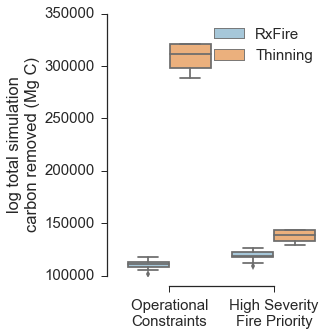

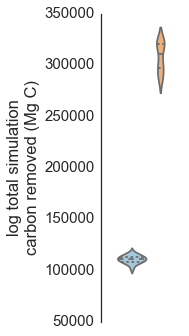

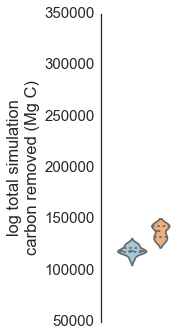

In [201]:
f, ax1 = plt.subplots(1,1, figsize =(5,5))

sns.boxplot(x="TRTMNT", y="MgBiomassRemoved", hue="PRESCRIP", 
            data=tlogSum, ax = ax1, order = ['OpCon','HFSP'], 
            palette=['#9ecae1','#fdae6b'])
sns.set_style('ticks')
sns.set_context('notebook',font_scale=1.5)

ax1.set_xticklabels(['Operational \nConstraints', 
                     'High Severity \nFire Priority'])
ax1.set_ylabel('log total simulation \ncarbon removed (Mg C)')
ax1.set_xlabel('')
sns.despine(offset=10, trim=True)
ax1.legend(title = '')
plt.tight_layout()
plt.savefig('Mgmt_C_Removed_TwinBox.tif', dpi = 300)

f, ax1 = plt.subplots(1,1, figsize =(3,5))
tlogSum_OpCon = tlogSum[tlogSum.TRTMNT == 'OpCon']
sns.violinplot(x="TRTMNT", y="MgBiomassRemoved", hue="PRESCRIP", 
            data=tlogSum_OpCon, ax = ax1, inner = 'quartile',
            palette=['#9ecae1','#fdae6b'])
sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)

ax1.set_xticklabels([''])
ax1.set_ylabel('log total simulation \ncarbon removed (Mg C)')
ax1.set_xlabel('')
sns.despine(offset=10, trim=True)
ax1.legend_.remove()
plt.tight_layout()
plt.savefig('Mgmt_C_Removed_OpCon.tif', dpi = 300)

f, ax2 = plt.subplots(1,1, figsize =(3,5))
tlogSum_HSFP = tlogSum[tlogSum.TRTMNT == 'HFSP']
sns.violinplot(x="TRTMNT", y="MgBiomassRemoved", hue="PRESCRIP", 
            data=tlogSum_HSFP, ax = ax2, inner = 'quartile',
            palette=['#9ecae1','#fdae6b'])
sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)

ax2.set_xticklabels([''])
ax2.set_ylabel('log total simulation \ncarbon removed (Mg C)')
ax2.set_xlabel('')
ax2.legend_.remove()
ax2.set_ylim([50000, 350000])
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig('Mgmt_C_Removed_HSFP.tif', dpi = 300)


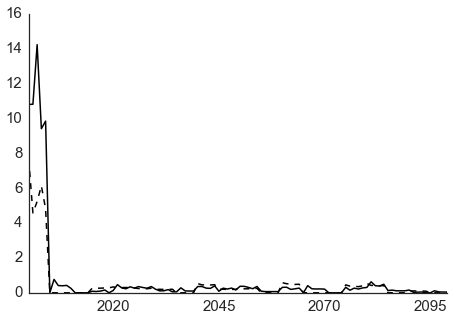

In [355]:
tlogMean = tlogTot.groupby(['TRTMNT','Time','PRESCRIP','REP']).sum()
tlogMean = tlogMean.reset_index()
tlogMean = tlogMean.groupby(['TRTMNT','Time','PRESCRIP']).mean()
tlogMean = tlogMean.reset_index()

activeCells = 45256.0
tlogMean['AreaWeightedThin'] = tlogMean.MgBiomassRemoved / activeCells

tlogHFSP = tlogMean[tlogMean.TRTMNT == 'HFSP']
tlogOpCon = tlogMean[tlogMean.TRTMNT == 'OpCon']

HSFPThinTS_tot = tlogHFSP.groupby(['Time']).sum()
tlogOpConTS_tot = tlogOpCon.groupby(['Time']).sum()

Time_100 = np.arange(1,101,1)
HSFPThinTS_tot = HSFPThinTS_tot.reindex(Time_100, fill_value=0)
tlogOpConTS_tot = tlogOpConTS_tot.reindex(Time_100, fill_value=0)

index = pd.date_range('2000-1-1', periods=len(HSFPThinTS_tot), freq='1A')
HSFPThinTS_tot.index = index

index = pd.date_range('2000-1-1', periods=len(tlogOpConTS_tot), freq='1A')
tlogOpConTS_tot.index = index

f, ax1 = plt.subplots(1,1, figsize =(7.5,5))
tlogOpConTS_tot.AreaWeightedThin.plot(ax = ax1, lw = 1.5, linestyle = '-', 
                color = 'black', label = 'Operational Constraint')
HSFPThinTS_tot.AreaWeightedThin.plot(ax = ax1, lw = 1.5, linestyle = '--', 
                color = 'black', label = 'Operational Constraint')

sns.despine()
